<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detection_(Mosquito_Borne_Disease).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims to apply the outbreak detection to the mosquito-borne-disease  dataset from https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0009259

In [1]:
# Download the packages if not already available
packages_needed <- c("readxl","surveillance", "forecast", "stringi", "lubridate", "scanstatistics", "reticulate", "rsatscan")
packages_to_install <- packages_needed[!(packages_needed %in% installed.packages()[,"Package"])]

if(length(packages_to_install)) {
  install.packages(packages_to_install)
}
lapply(packages_needed, library, character.only = TRUE)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.utils’, ‘deldir’, ‘polyclip’, ‘quadprog’, ‘quantmod’, ‘sp’, ‘polyCub’, ‘spatstat.geom’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘ismev’, ‘plyr’, ‘sets’, ‘RcppTOML’, ‘here’, ‘png’


Loading required package: sp

Loading required package: xtable

This is surveillance 1.25.0; see ‘package?surveillance’ or
https://surveillance.R-Forge.R-project.org/ for an overview.

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:surveillance’:

    ses



Attaching package: ‘lubridate’


The following object is masked from ‘package:surveillance’:

    year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


rsat

[[1]]
[1] "readxl"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
 [1] "surveillance" "xtable"       "sp"           "readxl"       "stats"       
 [6] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[11] "base"        

[[3]]
 [1] "forecast"     "surveillance" "xtable"       "sp"           "readxl"      
 [6] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[11] "methods"      "base"        

[[4]]
 [1] "stringi"      "forecast"     "surveillance" "xtable"       "sp"          
 [6] "readxl"       "stats"        "graphics"     "grDevices"    "utils"       
[11] "datasets"     "methods"      "base"        

[[5]]
 [1] "lubridate"    "stringi"      "forecast"     "surveillance" "xtable"      
 [6] "sp"           "readxl"       "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[6]]
 [1] "scanstatistics" "lubridate"      "stringi"        "forecast"      
 [5] "surveillance"   "xtable"         "sp"             "readxl"        
 [9] "stats"          "graphics"       "grDevices"      "utils"         
[13] "datasets"       "methods"        "base"          

[[7]]
 [1] "reticulate"     "scanstatistics" "lubridate"      "stringi"       
 [5] "forecast"       "surveillance"   "xtable"         "sp"            
 [9] "readxl"         "stats"          "graphics"       "grDevices"     
[13] "utils"          "datasets"       "methods"        "base"          

[[8]]
 [1] "rsatscan"       "reticulate"     "scanstatistics" "lubridate"     
 [5] "stringi"        "forecast"       "surveillance"   "xtable"        
 [9] "sp"             "readxl"         "stats"          "graphics"      
[13] "grDevices"      "utils"          "datasets"       "methods"       
[17] "base"

In [2]:
library(readxl)
library(stringi)

library(surveillance)
library(scanstatistics)

library(dplyr)
library(ggplot2)
library(tidyr)
library(tibble)

library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Download Dataset

In [3]:
url <- "https://journals.plos.org/plosntds/article/file?type=supplementary&id=info:doi/10.1371/journal.pntd.0009259.s001"
download.file(url, destfile = "data.xlsx", mode = "wb")

# Focusing on the first sheet where the data is
excel_sheets("data.xlsx")
data0 <- read_excel("data.xlsx", sheet = 1)
cat("The columns are:", paste(colnames(data0), collapse = ", "), "\n")

# Since the interest is only on the mosquito borne diseases, I take only the first 8 columns
data <- bind_cols(data0[1:8], data0$Population)
names(data)[9] <- "Population"

# Remove the spanish accent (Sorry, this is due to my US keyboard)
data$Municipality <- stri_trans_general(data$Municipality, "Latin-ASCII")

head(data)

[1] "Data"             "Variables Legend"

The columns are: Municipality, Year, Week, Chikungunya incidence, Dengue incidence, Severe dengue incidence, Zika incidence, Total arbovirus incidence, Tmax, Tmin, Tavg, Precipitation, Havg, Wsmax, Wsmin, WSavg, Elevation, Population, MPI, Illiteracy, Low Educational Achievement, School lag, School absence, Barriers to childhood services, Child labour, No health insurance, Barriers to health services, Informal work, Dependency rate, No access improved water, Inadequate excreta disposal, Inappropriate flooring material, Inappropriate wall exterior, Critical overcrowding 


New names:
• `` -> `...9`


Municipality Year Week Chikungunya incidence Dengue incidence
1 Bello        2007 1    0                     0               
2 Bello        2007 2    0                     0               
3 Bello        2007 3    0                     0               
4 Bello        2007 4    0                     0               
5 Bello        2007 5    0                     0               
6 Bello        2007 6    0                     0               
  Severe dengue incidence Zika incidence Total arbovirus incidence Population
1 0                       0              0                         388401    
2 0                       0              0                         388401    
3 0                       0              0                         388401    
4 0                       0              0                         388401    
5 0                       0              0                         388401    
6 0                       0              0                         388401

In [4]:
mun = unique(data$Municipality)
cat("The municipalities in the dataset are:",paste(mun, collapse = ", "))

The municipalities in the dataset are: Bello, Cucuta, Moniquira

In [5]:
data_mun <- split(data, data$Municipality)

# Data Visualization

In [6]:
illness <- c("Chikungunya incidence", "Dengue incidence", "Severe dengue incidence", "Zika incidence")

In [7]:
plot_incidence <- function(df_list, illness, plot_title = NULL) {

  # Combine all municipalities into one dataframe
  plot_df <- bind_rows(
    lapply(names(df_list), function(mun) {
      df <- df_list[[mun]]
      df$Municipality <- mun
      df
    })
  )

  # Make the year and week information into a proper date format
  plot_df <- plot_df %>%
    mutate(Date = as.Date(paste(Year, Week, 1, sep = "-"), format = "%Y-%U-%u"))

  illness_sym <- rlang::sym(illness)
  plot_title <- illness

  options(repr.plot.width = 20, repr.plot.height = 8)
  ggplot(plot_df, aes(x = Date, y = !!illness_sym, color = Municipality)) +
    geom_line(size = 1) +
    labs(
      title = plot_title,
      x = "Year-Week",
      y = "Incidence"
    ) +
    theme_minimal(base_size = 20) +
    theme(
      axis.text.x = element_text(angle = 0, hjust = 1)
    )
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


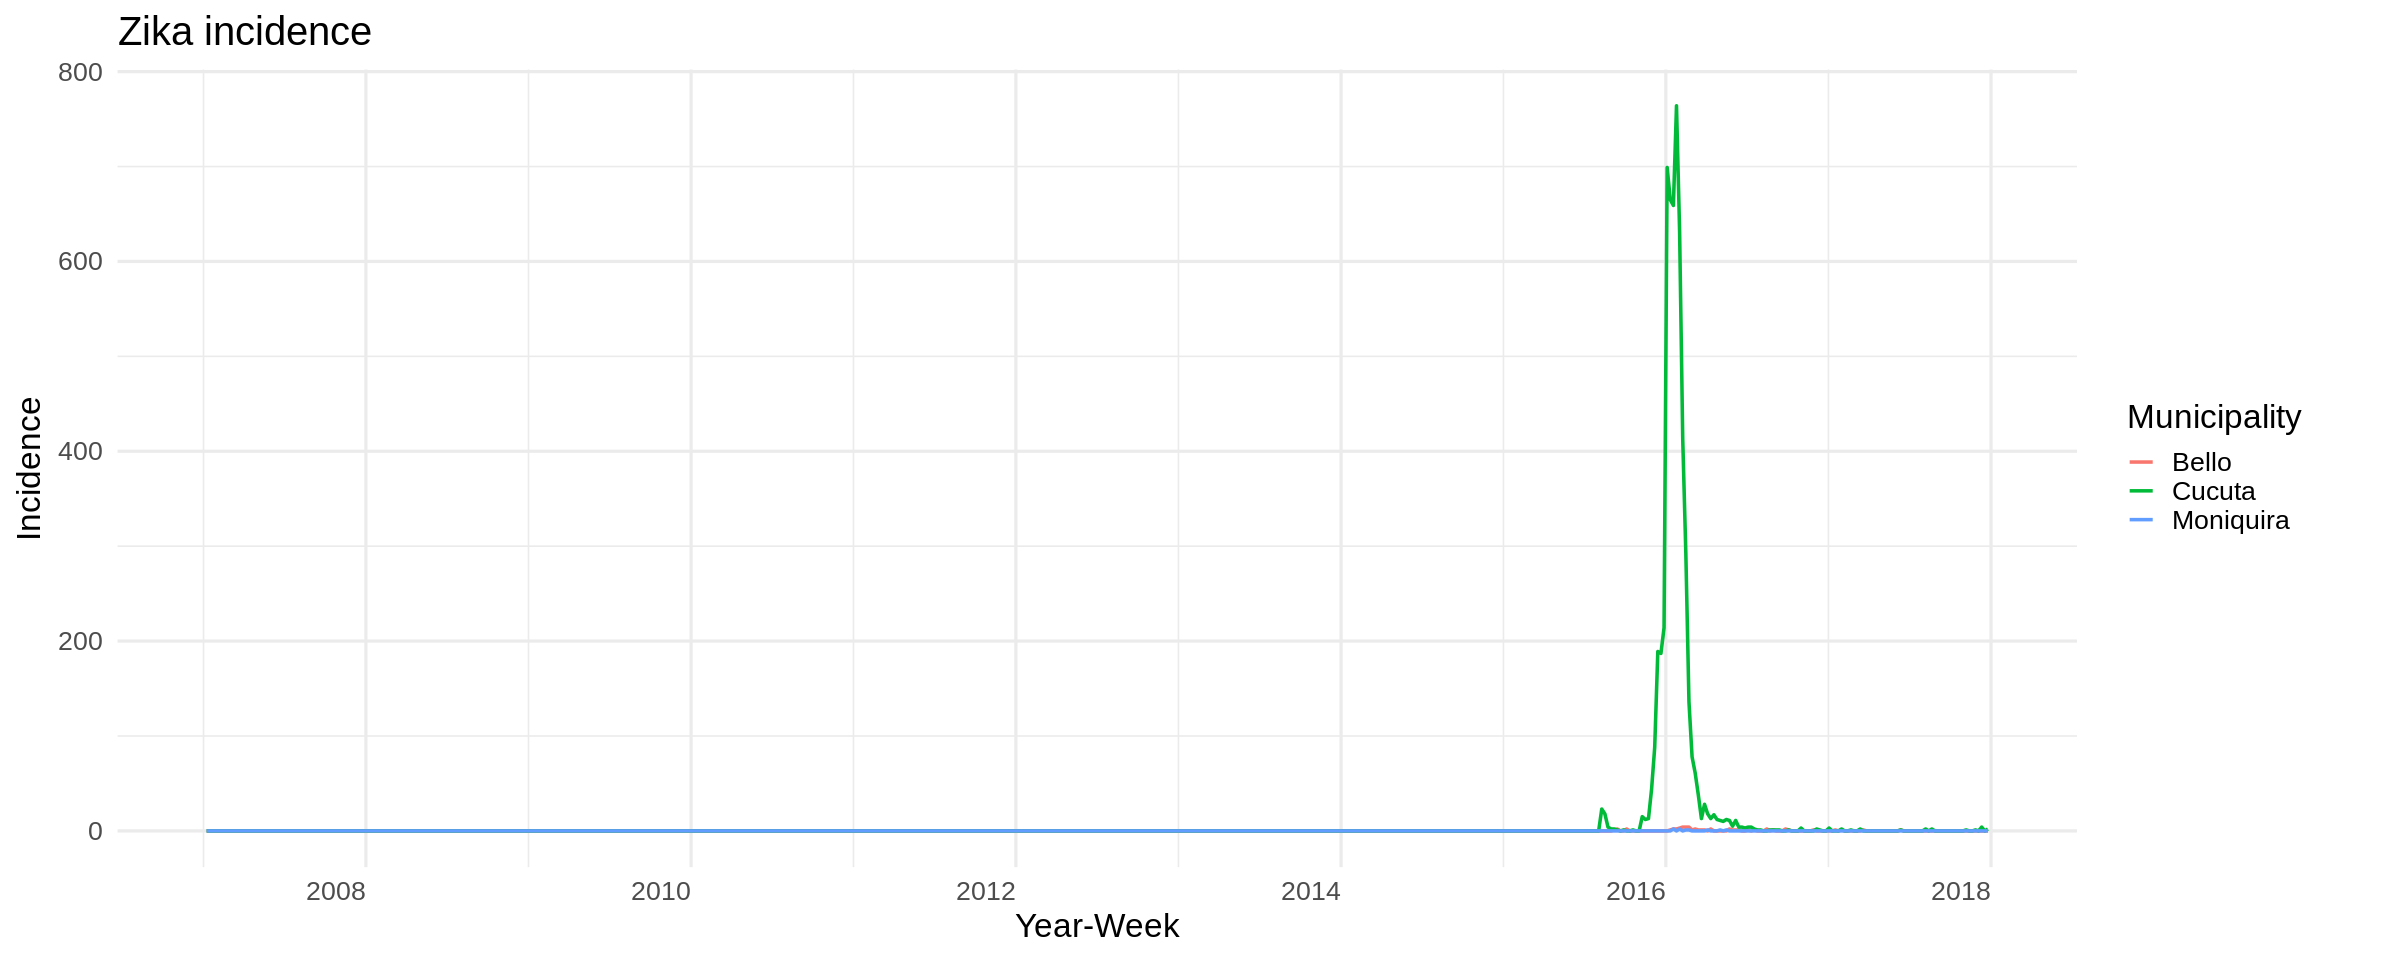

In [8]:
plot_incidence(data_mun, "Zika incidence")

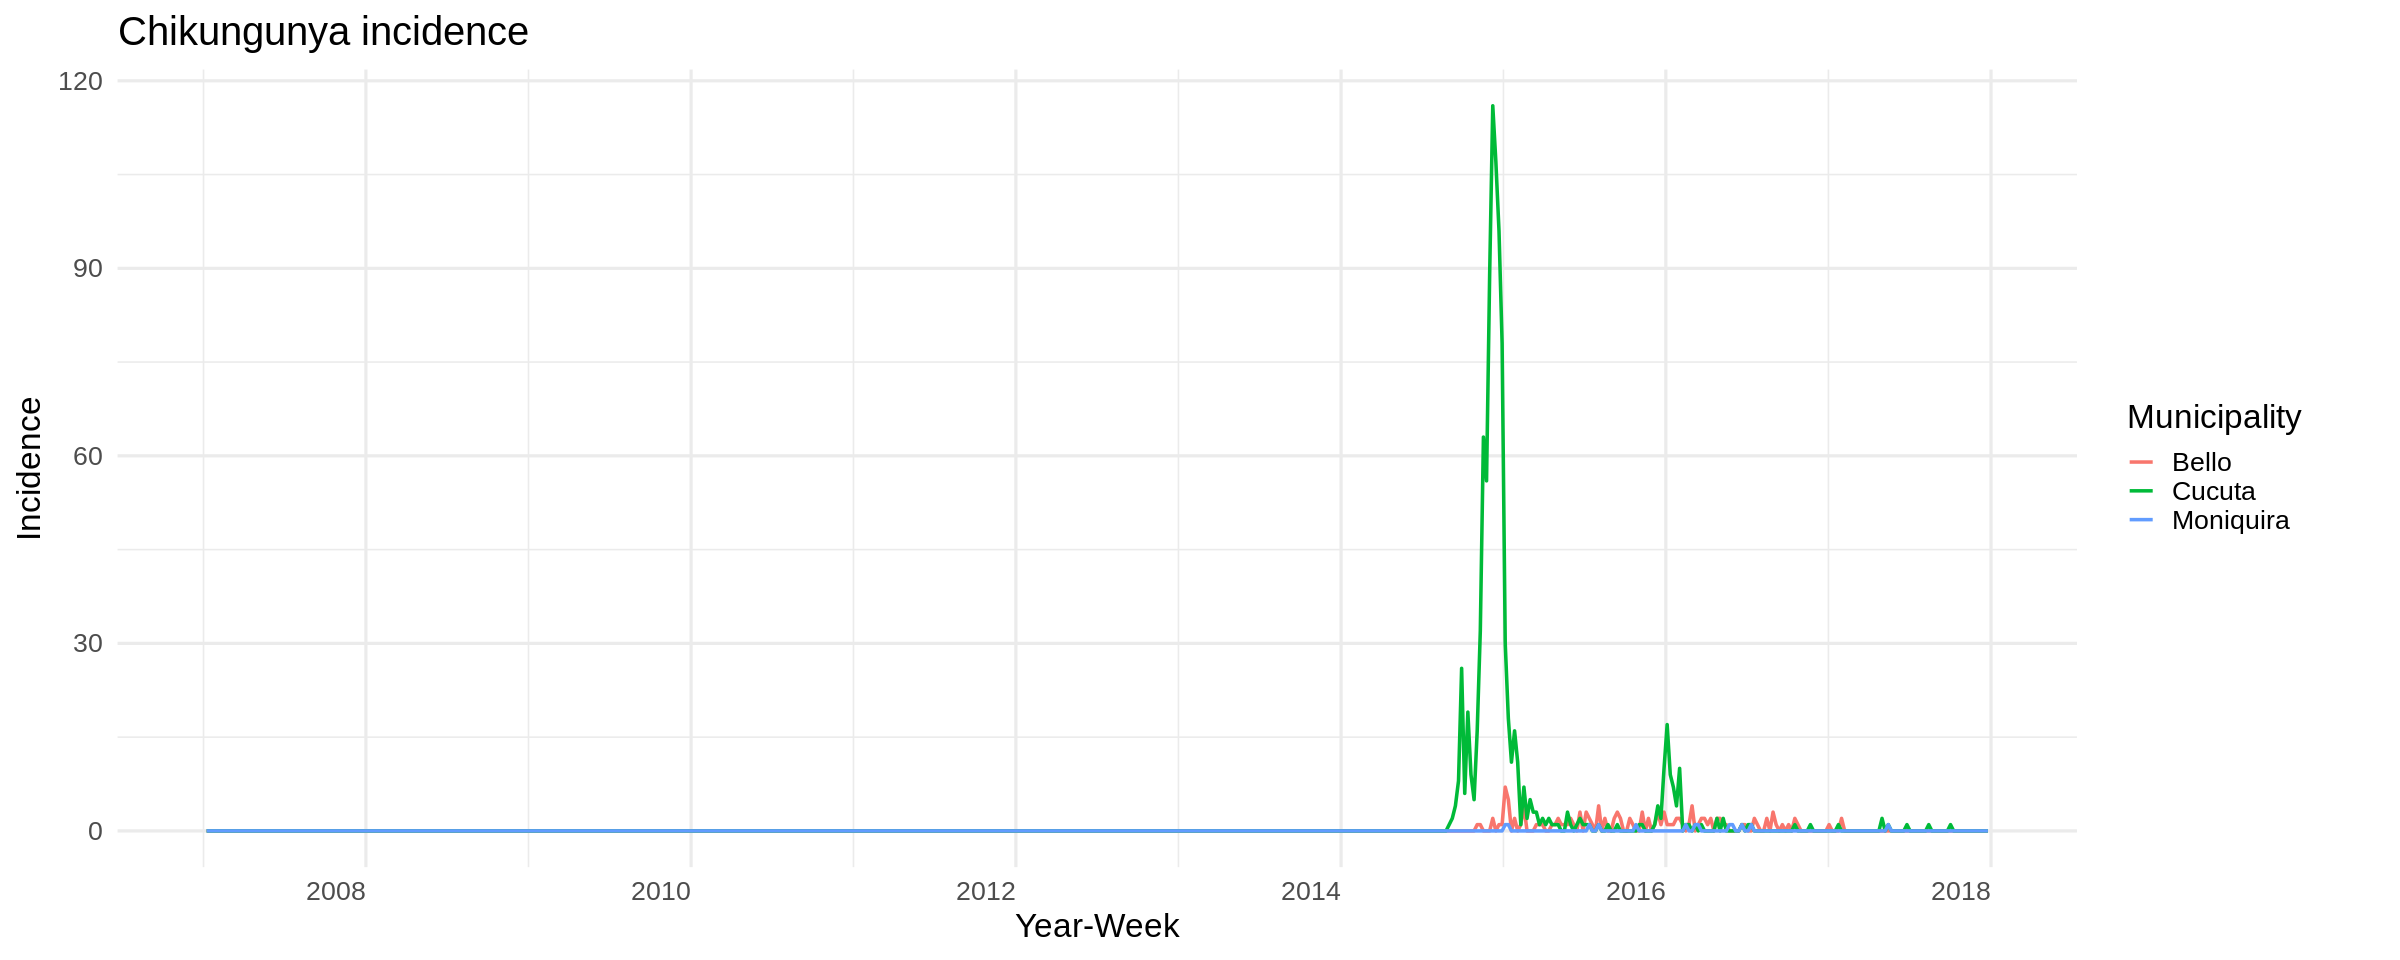

In [9]:
plot_incidence(data_mun, "Chikungunya incidence")

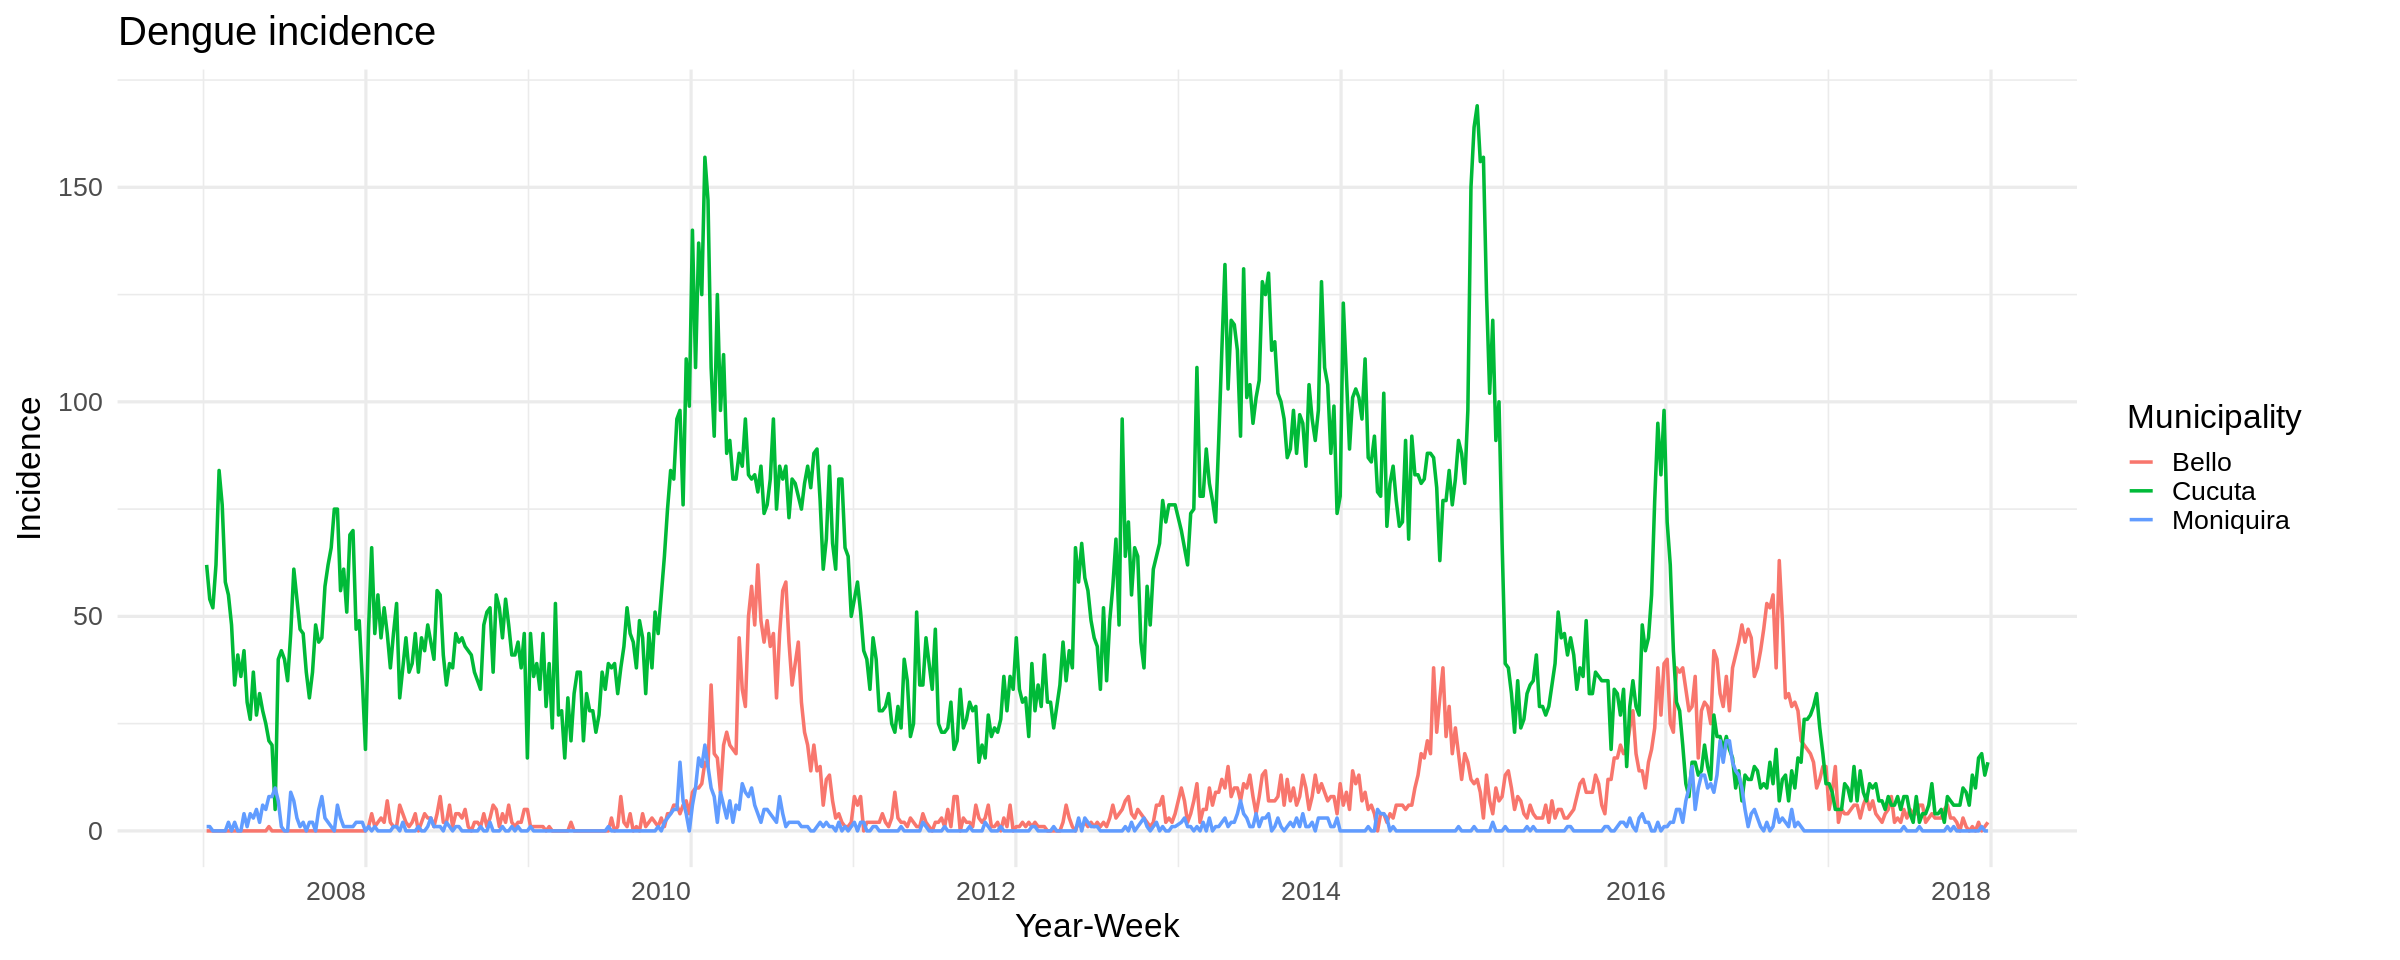

In [10]:
plot_incidence(data_mun, "Dengue incidence")

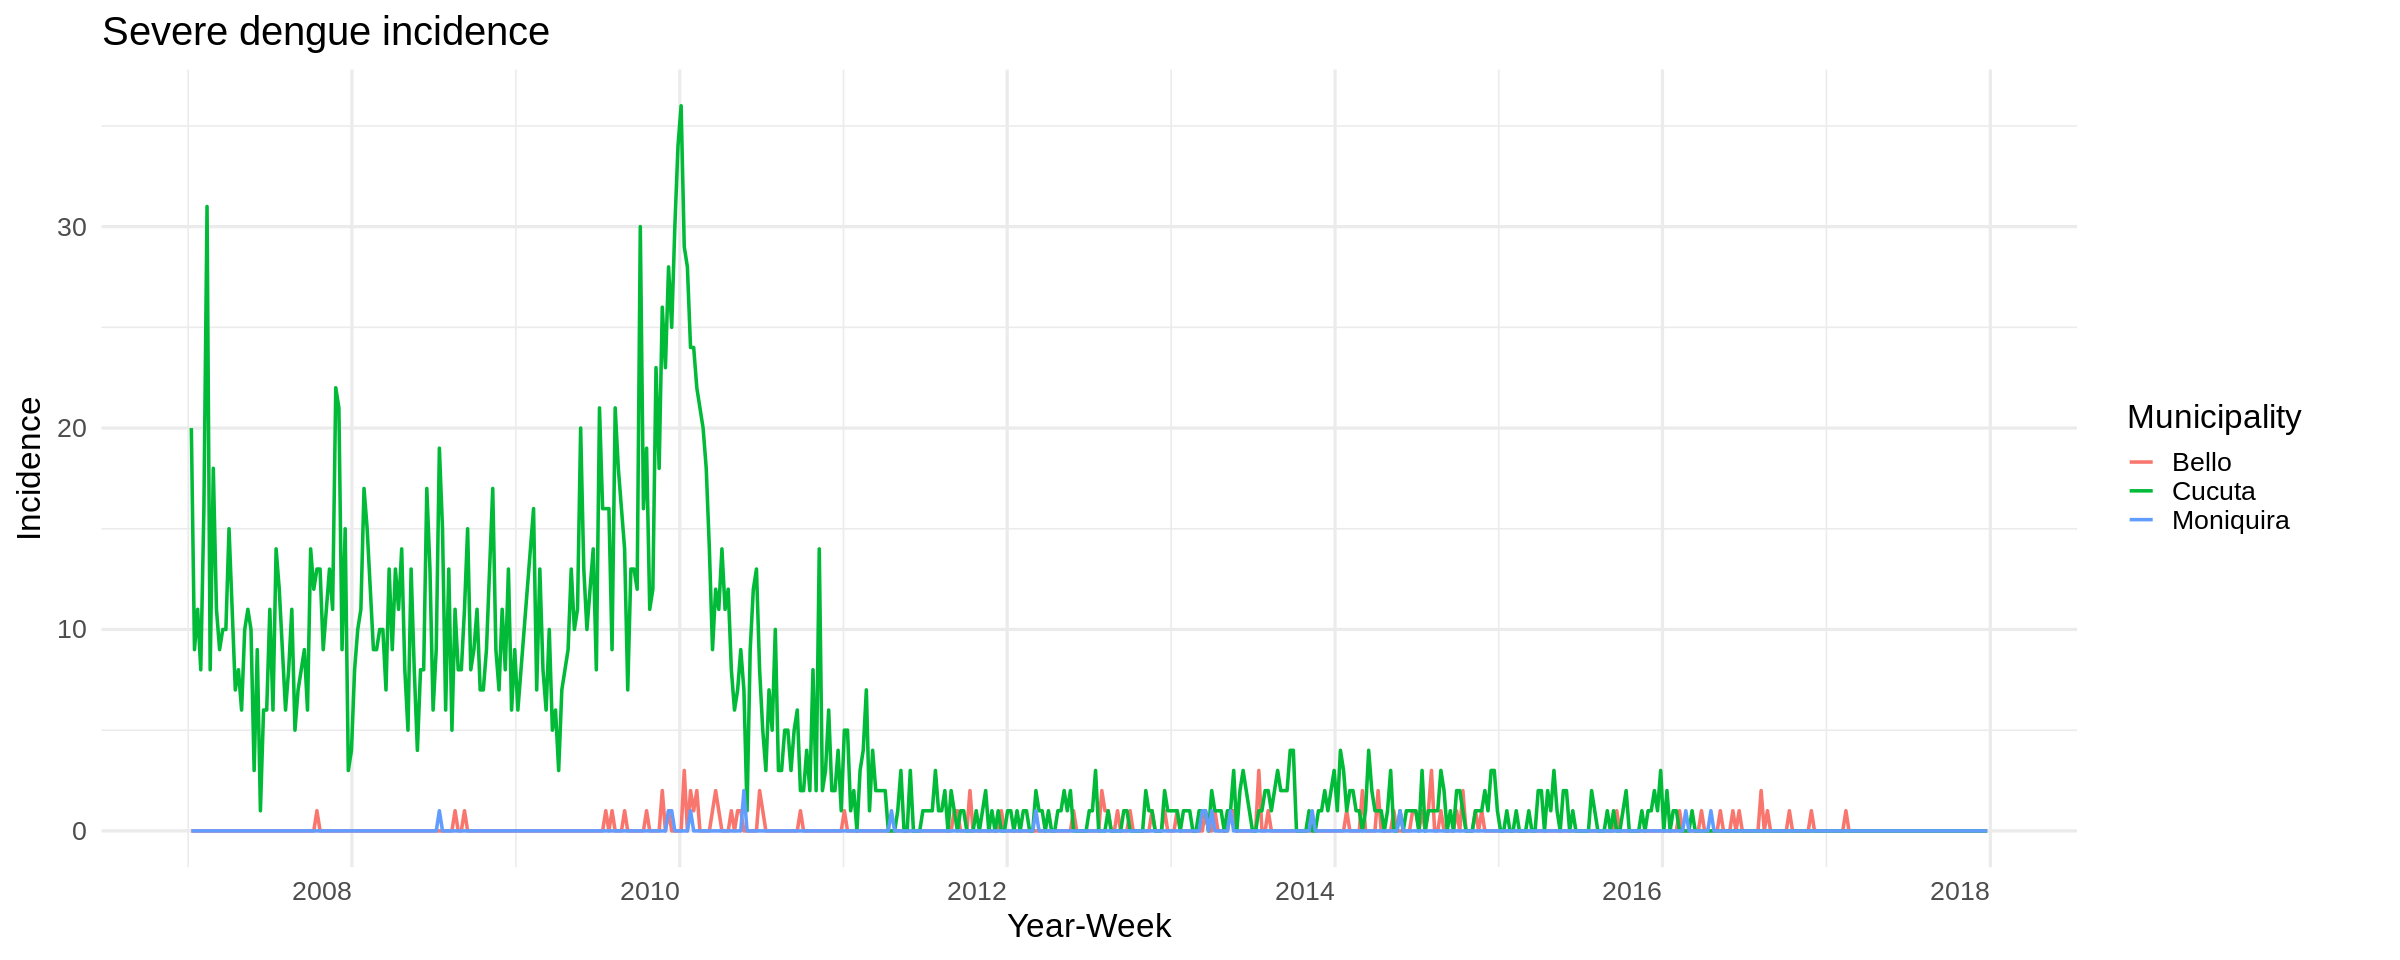

In [11]:
plot_incidence(data_mun, "Severe dengue incidence")

- After looking at the data, I'd focus on the Dengue for now
- I am not so sure if I should combine Dengue and Severe Dengue or not. I think it is not a problem to combine them especially since the severe dengue incidence is not a subset of dengue incidence, therefore combining the two would not results in double-counting.

In [12]:
# Combine dengue and severe dengue incidence
dd <- data %>%
  mutate(Dengue_total = `Dengue incidence` + `Severe dengue incidence`) %>%
  select(Municipality, Year, Week, Dengue_total, Population)

# rewrite the data by municipality since the focus is now only on the dengue
data_by_mun <- split(dd, data$Municipality)
cucuta_dengue <- data_by_mun$Cucuta
bello_dengue <- data_by_mun$Bello
moni_dengue <- data_by_mun$Moniquira

In [13]:
cols <- c("Municipality", "Year", "Week", "Dengue_total", "Population")
cucuta_dengue <- cucuta_dengue[, cols]
bello_dengue <- bello_dengue[, cols]
moni_dengue <- moni_dengue[, cols]

In [14]:
head(cucuta_dengue,2)

Municipality Year Week Dengue_total Population
1 Cucuta       2007 1    82           599905    
2 Cucuta       2007 2    63           599905

In [15]:
head(bello_dengue,2)

Municipality Year Week Dengue_total Population
1 Bello        2007 1    0            388401    
2 Bello        2007 2    0            388401

In [16]:
head(moni_dengue, 2)

Municipality Year Week Dengue_total Population
1 Moniquira    2007 1    1            21785     
2 Moniquira    2007 2    1            21785

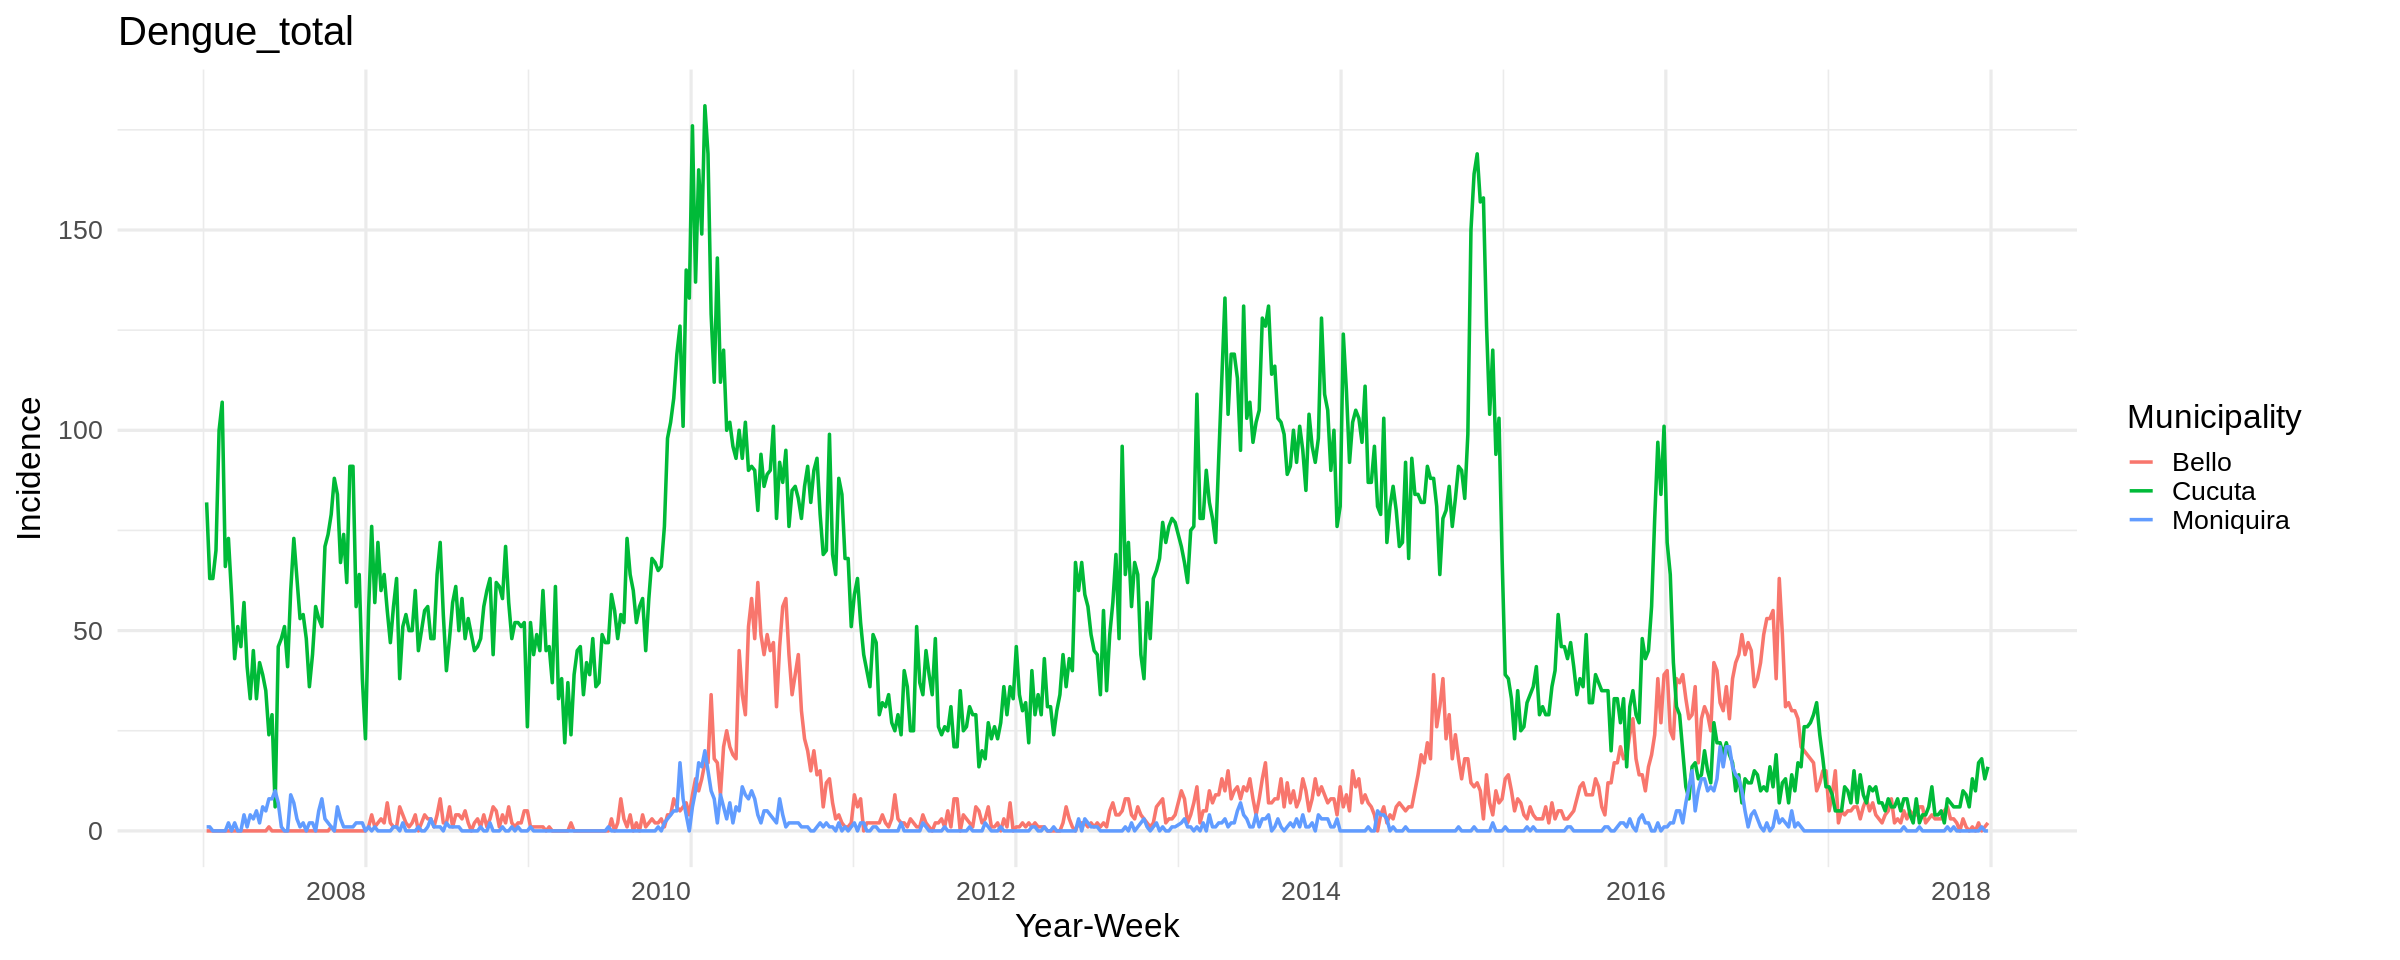

In [17]:
dengue_mun <- list(
  "Cucuta" = cucuta_dengue,
  "Bello" = bello_dengue,
  "Moniquira" = moni_dengue
)
plot_incidence(dengue_mun, "Dengue_total", plot_title = "Total Dengue Incidence")

# **Detection Functions (Farrington Flexible, EARS, ARIMA)**

In [18]:
detect_farrington_flex <- function(df, b = 1, w = 1, noPeriods = 1, pastWeeksNotIncluded = 0, trend = FALSE) {

  # Create the sts object
  sts_week <- sts(observed = df$Reported_Cases, freq = 1)

  # Run Farrington Flexible
  farr_week <- farringtonFlexible(
    sts_week,
    control = list(
      b = b, w = w, noPeriods = noPeriods,
      pastWeeksNotIncluded = pastWeeksNotIncluded,
      trend = trend,
      alpha = 0.05
    )
  )

  # Just taking the variable to match the week with the alarm
  n_result <- length(observed(farr_week))
  max_week <- max(df$Week)

  # Store the "forecast" values
  forecast_df <- tibble::tibble(
    target_week = (max_week - n_result + 1):max_week,
    actual_value = observed(farr_week),
    upper_bound = upperbound(farr_week),
    p_val = farr_week@control$pvalue,
    Alarm = as.numeric(alarms(farr_week) > 0)
  )

  return(list(signal = forecast_df$Alarm, p_val = farr_week@control$pvalue, forecast = forecast_df))
}


In [19]:
# EARS detection
detect_ears <- function(df, method = "C3", baseline = 100) {
  # Convert to sts object
  sts_cases <- sts(observed = df$Reported_Cases, freq = 1)
  # EARS with the method can be C1/C2/C3 and baseline is the temporal window
  ears <- earsC(sts_cases, control = list(method = method, baseline = baseline))

  # Just taking the variable to match the week with the alarm
  n_result <- length(observed(ears))
  max_week <- max(df$Week)

  # Store the "forecast" values
  forecast_df <- tibble::tibble(
    target_week = (max_week - n_result + 1):max_week,
    actual_value = observed(ears),
    upper_bound = upperbound(ears),
    Alarm = as.numeric(alarms(ears) > 0),

  )

  return(list(signal = forecast_df$Alarm, forecast = forecast_df))
}

In [20]:
# ARIMA detection
detect_arima <- function(df, window_size = 100, interval = 0.95, jump = 1) {
  # Parameters:
  # df = input data
  # window_size = initial training size (burn-in)
  # interval = confidence level for prediction interval (e.g., 0.95)
  # jump = number of days to move the forecast window forward

  n <- nrow(df)  # Total number of timepoints
  arima_signal <- rep(0, n)  # Initialize outbreak signal (0 = no alarm)
  forecast_records <- list()  # List to store forecast info

  t <- window_size + 1  # Start detection after initial training window

  while (t <= n) {
    start_day <- 1  # Expanding window always starts from day 1
    train_data <- df$Reported_Cases[start_day:(t - 1)] # Train data since day one untill yesterday/last week to get the predicted now

    # Fit ARIMA model on training data
    arima_fit <- auto.arima(train_data)

    # Forecast next few days (up to jump days or until end)
    h <- min(jump, n - t + 1)
    preds <- forecast(arima_fit, h = h, level = interval * 100)

    # Extract upper bounds and means
    uppers <- preds$upper[, 1]
    lowers <- preds$lower[, 1]
    means <- preds$mean

    # Loop through forecast horizon
    for (j in 0:(h - 1)) {
      tt <- t + j  # Actual index in data
      if (tt > n) break

      actual_value <- df$Reported_Cases[tt]

      ### Because there is no significant or p-val for the alarm, I need to count it mannually
      # Calculate the standard deviation
      z_score <- qnorm(interval)
      forecast_se <- (uppers[j + 1] - means[j + 1]) / z_score
      # Calculate the p-val of finding the actual value given the distribution of the forecast
      pval <- 1 - pnorm(actual_value, mean = means[j + 1], sd = forecast_se)


      # I want to safe the forecast results
      forecast_records[[length(forecast_records) + 1]] <-  tibble::tibble(
        forecast_week = df$Week[t],
        target_week = df$Week[tt],
        forecast_mean = means[j + 1],
        upper_bound = uppers[j + 1],
        lower_bound = lowers[j + 1],
        actual_value = actual_value,
        p_val = pval
      )

      # Raise alarm if actual value exceeds prediction upper bound
      if (actual_value > uppers[j + 1]) {
        arima_signal[tt] <- 1
      }
    }

    t <- t + jump  # Move the forecasting step forward
  }

  # Construct forecast data frame and trim signal to post-burn-in
  forecast_df <- do.call(rbind, forecast_records)
  arima_signal_trimmed <- arima_signal[(window_size + 1):n]


  return(list(
    signal = arima_signal_trimmed,
    p_val = forecast_df$p_val,
    forecast_df = forecast_df
  ))
}

### Scan Statistics

In [21]:
# This function purpose is to make a start and end year indexing for the window
data_to_window <- function(years_all, window_years = 2) {
  starts <- seq(1, length(years_all), by = window_years)
  ends <- pmin(starts + window_years - 1, length(years_all))
  return(tibble(start_year = years_all[starts], end_year = years_all[ends]))
}

In [22]:
# This function runs scanstatistics
run_scan_window <- function(window_df) {

  window_df <- window_df %>% rename(count = Dengue_total)

  window_df <- window_df %>%
    group_by(Municipality) %>%
    arrange(Year, .data$Week, .by_group = TRUE) %>%
    mutate(time = row_number()) %>%
    ungroup()

  window_df <- window_df %>% mutate(location = as.integer(factor(Municipality)))

  region_lookup <- tibble(
    Municipality = levels(factor(window_df$Municipality)),
    region_id = seq_along(levels(factor(window_df$Municipality)))
  )

  region_names <- region_lookup$Municipality

  # Create the zones combination to be tested
  n_regions <- length(region_names)

  df_zones <- unlist(
    lapply(1:n_regions, function(k) combn(n_regions, k, simplify = FALSE)),
    recursive = FALSE
  )

  # Cataloging the zones in dataframe format
  zones_cat <- data.frame(
    zone_id = seq_along(df_zones),
    zone_regions = vapply(
      df_zones,
      function(indices) paste(region_names[indices], collapse = ", "),
      character(1L)
    ),
    stringsAsFactors = FALSE
  )

  scan_result <- scan_pb_poisson(window_df,zones = df_zones, n_mcsim = 999)

  return(list(
    result = scan_result,
    df_zones = df_zones,
    zones_cat = zones_cat
  ))
}


In [23]:
# Extract the significant (p<0.05) cluster
extract_significant_clusters <- function(scan_result, window_info, df_zones, p_thres, top_k_clust) {

  clusters <- top_clusters(scan_result$result,zones = df_zones, k = top_k_clust,overlapping = FALSE)
  significant_clusters <- clusters %>% filter(MC_pvalue < p_thres)

  if (nrow(significant_clusters) > 0) {
    significant_clusters <- significant_clusters %>%
      mutate(window_start_year = window_info$start_year,
             window_end_year = window_info$end_year)}
  return(significant_clusters)
}

In [24]:
set.seed(1212)

detect_statscan <- function(df, window_years = 2, p_thres = 0.05,top_k_clust = 1) {

  # Build time windows
  years_all <- sort(unique(df$Year))
  window_ranges <- data_to_window(years_all, window_years)

  all_sig_clusters <- list()

  # Loop over windows
  for (i in seq_len(nrow(window_ranges))) {

    this_window <- window_ranges[i, ]
    message(paste0("Running scan for ",this_window$start_year, "-",this_window$end_year))

    window_df <- df %>% filter(Year >= this_window$start_year,Year <= this_window$end_year)
    # Run the scan
    res <- run_scan_window(window_df)
    # Take the significant cluster, format to dataframe
    sig_clusters <- extract_significant_clusters(
      scan_result = res,
      window_info = list(start_year = this_window$start_year, end_year = this_window$end_year),
      df_zones = res$df_zones,
      p_thres = p_thres,
      top_k_clust = top_k_clust
    )

    # Take only the not null results (meaningfull results)
    if (!is.null(sig_clusters) && nrow(sig_clusters) > 0) {
      all_sig_clusters[[length(all_sig_clusters) + 1]] <- sig_clusters
    }
  }

  # Make into a summary
  sig_clusters_df <- bind_rows(all_sig_clusters)
  sig_clusters_df <- sig_clusters_df %>% left_join(res$zones_cat, by = c("zone" = "zone_id"))
  sig_clusters_df <- sig_clusters_df %>% select(zone, duration, MC_pvalue, window_start_year, window_end_year, zone_regions)
  sig_clusters_df <- sig_clusters_df %>% separate_rows(zone_regions, sep = ",\\s*")

  # Calulate when is the start of the outbreak
  sig_clusters_df <- sig_clusters_df %>%
  mutate(
    outbreak_start_year = window_start_year + floor(((window_end_year - window_start_year + 1) * 52 - duration) / 52),
    outbreak_start_week = (((window_end_year - window_start_year + 1) * 52 - duration) %% 52) + 1)

  return(sig_clusters_df)
}

# **Run The Analysis**

Note: The analysis is currently running slow. I might need to revisit the algorithm and do some optimization.

In [25]:
analyze_region <- function(df, detectors, region_id = NULL) {
  # Run all detectors, collect outputs
  detector_outputs <- lapply(detectors, function(f) f(df))

  # Get signals
  signals_list <- lapply(detector_outputs, function(x) x$signal)
  names(signals_list) <- names(detectors)

  # Get p-val if it is exist
  pval_list <- lapply(detector_outputs, function(x) {
    if ("p_val" %in% names(x)) x$p_val else NULL
  })
  keep <- !sapply(pval_list, is.null)
  pval_list <- pval_list[keep]
  names(pval_list) <- names(detectors)[keep]


  # Find minimum length (align different detector signal lengths)
  all_lengths <- sapply(signals_list, length)
  min_len <- min(all_lengths)

  # and trim signals
  signals_cut <- lapply(signals_list, tail, min_len)
  pval_cut <- lapply(pval_list, tail, min_len)

  # Also get forecasts if available
  forecast_list <- lapply(detector_outputs, function(x) tail(x$forecast, min_len))
  names(forecast_list) <- names(detectors)


  signals_df <- data.frame(Week = tail(df$Week, min_len),signals_cut )

  pval_df <- data.frame(Week = tail(df$Week, min_len), pval_cut, check.names = FALSE)
  pval_df <- pval_df %>% rename_with(~ paste0(.x, "_pval"), -Week)

  return(list(signals = signals_df, pval = pval_df, forecasts = forecast_list))
}

In [26]:
detectors <- list(
  Farrington_Flexible = detect_farrington_flex,
  EARS = detect_ears,
  ARIMA = detect_arima
)

### Cucuta Outbreak Detection

In [27]:
# Do some column renaming to fit the established framework, if not already modified
cucuta_dengue <- cucuta_dengue %>% rename(Reported_Cases = Dengue_total)
cucuta_dengue <- cucuta_dengue %>%
  rename(Week_inY = Week) %>%         # Rename 'Week' to 'Week_inY'
  mutate(Week = row_number())         # Do an indexing from 1 to N and named it as 'Week'

global_result_cucuta <- analyze_region(cucuta_dengue, detectors)

### Bello Outbreak Detection

In [28]:
# Do some column renaming to fit the established framework (perhaps to be made more general later)
bello_dengue <- bello_dengue %>% rename(Reported_Cases = Dengue_total)
bello_dengue <- bello_dengue %>%
  rename(Week_inY = Week) %>%         # Rename 'Week' to 'Week_inY'
  mutate(Week = row_number())         # Do an indexing from 1 to N and named it as 'Week'

global_result_bello <- analyze_region(bello_dengue, detectors)

### Moniquira Outbreak Detection

In [29]:
# Do some column renaming to fit the established framework (perhaps to be made more general later)
moni_dengue <- moni_dengue %>% rename(Reported_Cases = Dengue_total)
moni_dengue <- moni_dengue %>%
  rename(Week_inY = Week) %>%         # Rename 'Week' to 'Week_inY'
  mutate(Week = row_number())         # Do an indexing from 1 to N and named it as 'Week'

global_result_moni <- analyze_region(moni_dengue, detectors)

In [30]:
# global_result_moni$forecasts$Farrington_Flexible

### Scan Statistics

(It is separate as it requires more work to combine the workflow, for later work if necessary)

In [31]:
scan_res_11 <- detect_statscan(df = dd, window_years = 11, p_thres = 0.05, top_k_clust = 1)
scan_res_11

Running scan for 2007-2017

Warning message:
“`spread_()` was deprecated in tidyr 1.2.0.
ℹ Please use `spread()` instead.
ℹ The deprecated feature was likely used in the scanstatistics package.
  Please report the issue at
  <https://github.com/promerpr/scanstatistics/issues>.”


zone duration MC_pvalue window_start_year window_end_year zone_regions
1 5    102      0.001     2007              2017            Bello       
2 5    102      0.001     2007              2017            Moniquira   
  outbreak_start_year outbreak_start_week
1 2016                3                  
2 2016                3

In [32]:
scan_res_3 <- detect_statscan(df = dd, window_years = 3, p_thres = 0.05, top_k_clust = 1)
scan_res_3

Running scan for 2007-2009

Running scan for 2010-2012

Running scan for 2013-2015

Running scan for 2016-2017



zone duration MC_pvalue window_start_year window_end_year zone_regions
1 1    103      0.001     2007              2009            Bello       
2 2    116      0.001     2010              2012            Cucuta      
3 1     29      0.001     2013              2015            Bello       
4 2     60      0.001     2016              2017            Cucuta      
  outbreak_start_year outbreak_start_week
1 2008                 2                 
2 2010                41                 
3 2015                24                 
4 2016                45

In [33]:
format_scan_data <- function(dd, scan_res, trim_length_to = NULL) {

  # Take the information needed from the scan result
  scan_res_periods <- scan_res %>%
    select(
      Municipality      = zone_regions,
      outbreak_start_year,
      outbreak_start_week,
      window_end_year,
      MC_pvalue
    )

  # Take the period where it is flagged as outbreak
  outbreak_period <- dd %>%
    left_join(scan_res_periods, by = "Municipality") %>%
    filter(
      (Year >  outbreak_start_year) |
        (Year == outbreak_start_year & Week >= outbreak_start_week),
      Year <= window_end_year
    )

  # Outbreak period then flagged as signal 1
  outbreak_flag <- outbreak_period %>%
    mutate(signal = 1) %>%
    select(Municipality, Year, Week, MC_pvalue, signal)

  # Join back to the original dataframe
  dd_outbreak <- dd %>%
    left_join(outbreak_flag,
              by = c("Municipality", "Year", "Week")) %>%
    mutate(signal = ifelse(is.na(signal), 0L, signal), MC_pvalue = ifelse(signal == 0,NA, MC_pvalue))

  # Trim so that the length matches the other detectors
  if (!is.null(trim_length_to)) {
    dd_outbreak <- dd_outbreak %>%
      group_by(Municipality) %>%
      slice_tail(n = trim_length_to) %>%
      ungroup()
  }

  return(dd_outbreak)
}

In [40]:
scan_res_11y <- format_scan_data(dd, scan_res_11, trim_length_to = nrow(global_result_cucuta$signals))
head(scan_res_11y%>% filter(Municipality == 'Bello'),5)

Municipality Year Week Dengue_total Population MC_pvalue signal
1 Bello        2009 1    1            404895     NA        0     
2 Bello        2009 2    1            404895     NA        0     
3 Bello        2009 3    1            404895     NA        0     
4 Bello        2009 4    1            404895     NA        0     
5 Bello        2009 5    1            404895     NA        0

In [41]:
scan_res_3y <- format_scan_data(dd, scan_res_3, trim_length_to = nrow(global_result_cucuta$signals))
head(scan_res_3y%>% filter(Municipality == 'Bello'),5)

Warning message in left_join(., scan_res_periods, by = "Municipality"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


Municipality Year Week Dengue_total Population MC_pvalue signal
1 Bello        2009 1    1            404895     0.001     1     
2 Bello        2009 2    1            404895     0.001     1     
3 Bello        2009 3    1            404895     0.001     1     
4 Bello        2009 4    1            404895     0.001     1     
5 Bello        2009 5    1            404895     0.001     1

### Detection Visualization
There are 2 functions for plotting.


*   plot_detector_forecast is to plot the results of Farrington Flexible, ARIMA, and EARS
*   plot_scan is to plot the results of scan detector

The two diffferent function is because it is faster for me to make new separate one that to combine the two. Could be made better in the future, if needed.



In [42]:
plot_detector_forecast <- function(result, detector_name = "ARIMA", place) {
  forecast_df <- result$forecasts[[detector_name]]

  # Band aid method because the output from different detection methods are not the same (to be fixed)
  # If Alarm column in forecast tibble doesn't exist, join it from the signals data
  if (!"Alarm" %in% names(forecast_df)) {
    signal_df <- result$signals %>%
      select(Week, Alarm = all_of(detector_name))
    forecast_df <- forecast_df %>%
      left_join(signal_df, by = c("target_week" = "Week"))
  }

  options(repr.plot.width = 20, repr.plot.height = 8)
  p <- ggplot(forecast_df, aes(x = target_week))

  # If there is a column named "lower bound", then make a prediction range plot (ribbon)
  if ("lower_bound" %in% names(forecast_df) && "upper_bound" %in% names(forecast_df)) {
    p <- p + geom_ribbon(aes(ymin = lower_bound, ymax = upper_bound, fill = "Prediction Interval"), alpha = 1)
  } else if ("upper_bound" %in% names(forecast_df)) { # If no "lower bound", then just plot upper bound (threshold)
    p <- p + geom_line(aes(y = upper_bound, color = "Upper Bound (Threshold)"), size = 1, linetype = "dashed")
  }

  # Plot reported cases
  p <- p +
    geom_line(aes(y = actual_value, color = "Actual"), size = 1)

  # Alarms as dot
  p <- p + geom_point(data = filter(forecast_df, Alarm == 1),
                      aes(y = actual_value, color = "Alarm"), size = 2.5)

  p <- p +
    scale_color_manual(name = "Legend",
                       values = c("Actual" = "black", "Alarm" = "red", "Upper Bound (Threshold)" = "blue")) +
    scale_fill_manual(name = "Legend", values = c("Prediction Interval" = "lightblue")) +
    labs(title = paste("Weekly Outbreak Detection with", detector_name, "in", place),
         x = "Week", y = "Weekly Incidence") +
    theme_minimal(base_size = 20) +
    theme(legend.position = "top")

  return(p)
}

In [43]:
plot_scan <- function(df, region, extra_note = NULL) {

  plot_df <- df %>% filter(Municipality == region)

  first_week <- global_result_cucuta$signals$Week[1]   # So that the count of the week is the same as the other detectors

  plot_df <- plot_df %>%
    rename(Week_inY = Week) %>%
    mutate(Week = seq(from = first_week,
                       by   = 1,
                       length.out = n()))

  # Custom title
  title_base <- sprintf("Weekly Outbreak Detection with ScanStatistics in %s",region )
  full_title <- if (!is.null(extra_note) && nzchar(extra_note)) {
    paste(title_base, extra_note)
  } else {
    title_base
  }

  # PLot
  ggplot(plot_df, aes(x = Week)) +
  geom_line(aes(y = Dengue_total, color = "Actual"), size = 0.7) +
  geom_point(data = filter(plot_df, signal == 1),
             aes(y = Dengue_total, color = "Alarm"),
             size = 2) +

  scale_color_manual(
    name = "Legend",
    values = c("Actual" = "black","Alarm" = "red", "Upper Bound (Threshold)" = "blue")) +

  labs(title = full_title, x = "Week", y = "Weekly Incidence" ) +
  theme_minimal(base_size = 20) +
  theme(legend.position = "top", legend.title = element_text(face = "bold"))
}


### Plot Outbreak Cucuta

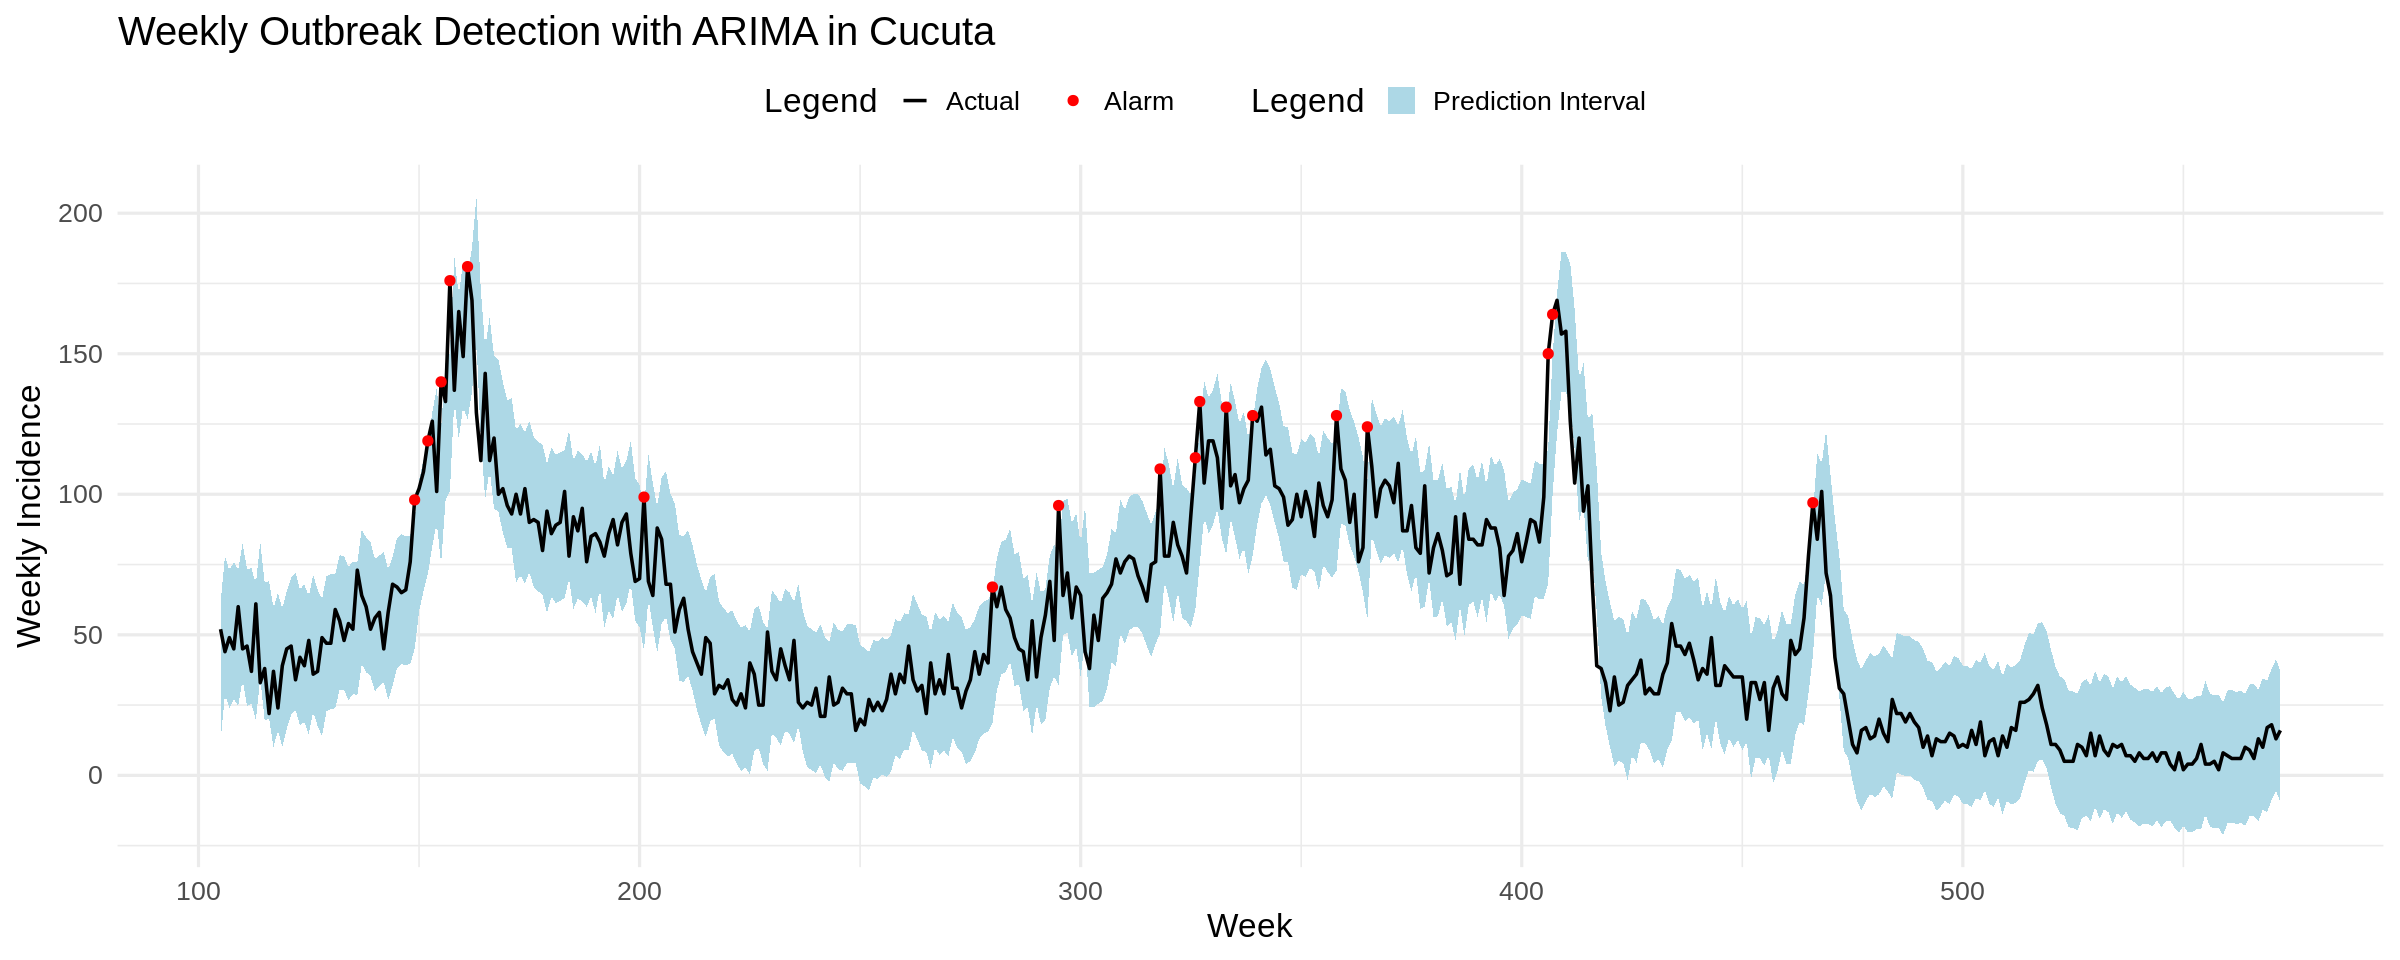

In [44]:
plot_detector_forecast(global_result_cucuta, "ARIMA", "Cucuta")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


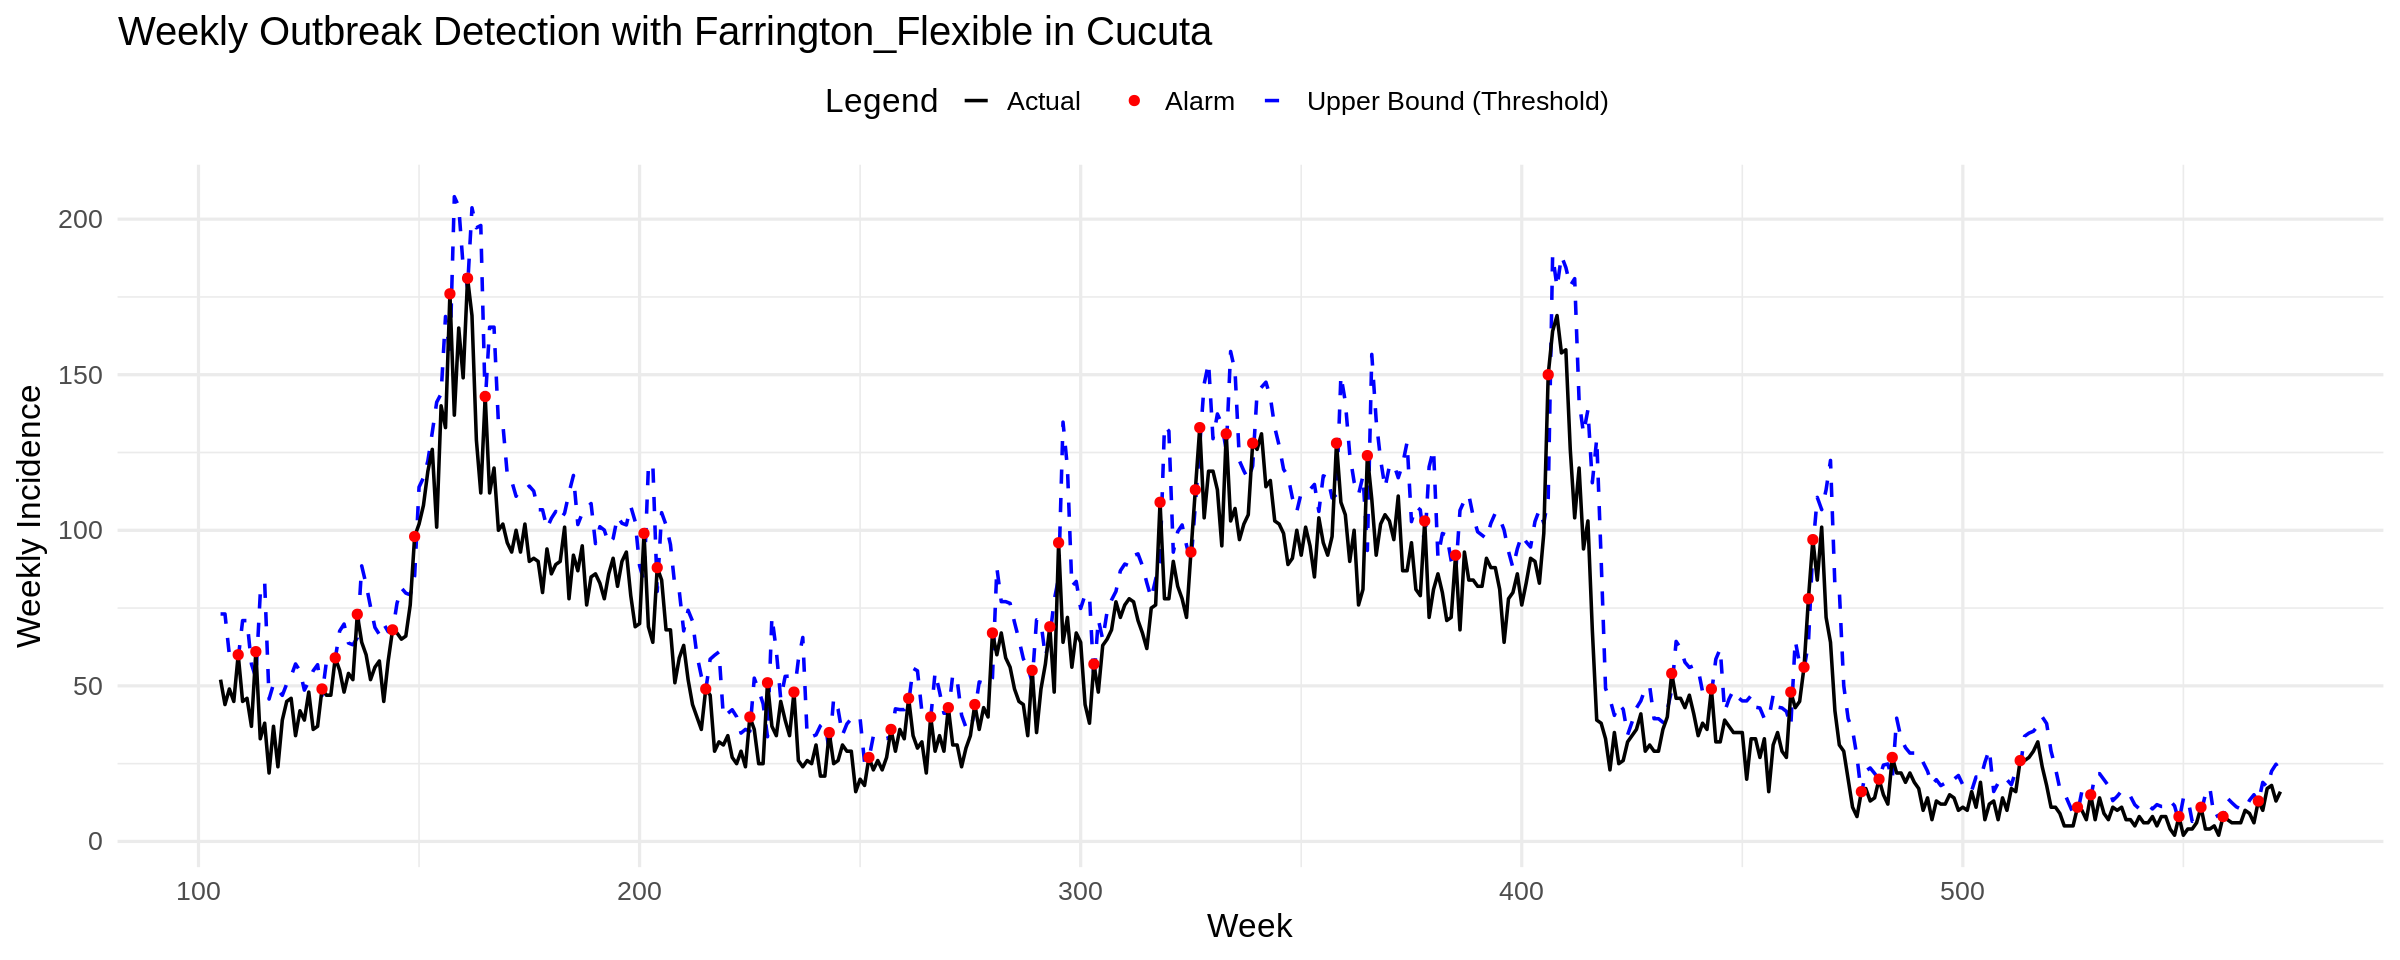

In [45]:
plot_detector_forecast(global_result_cucuta, "Farrington_Flexible", "Cucuta")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


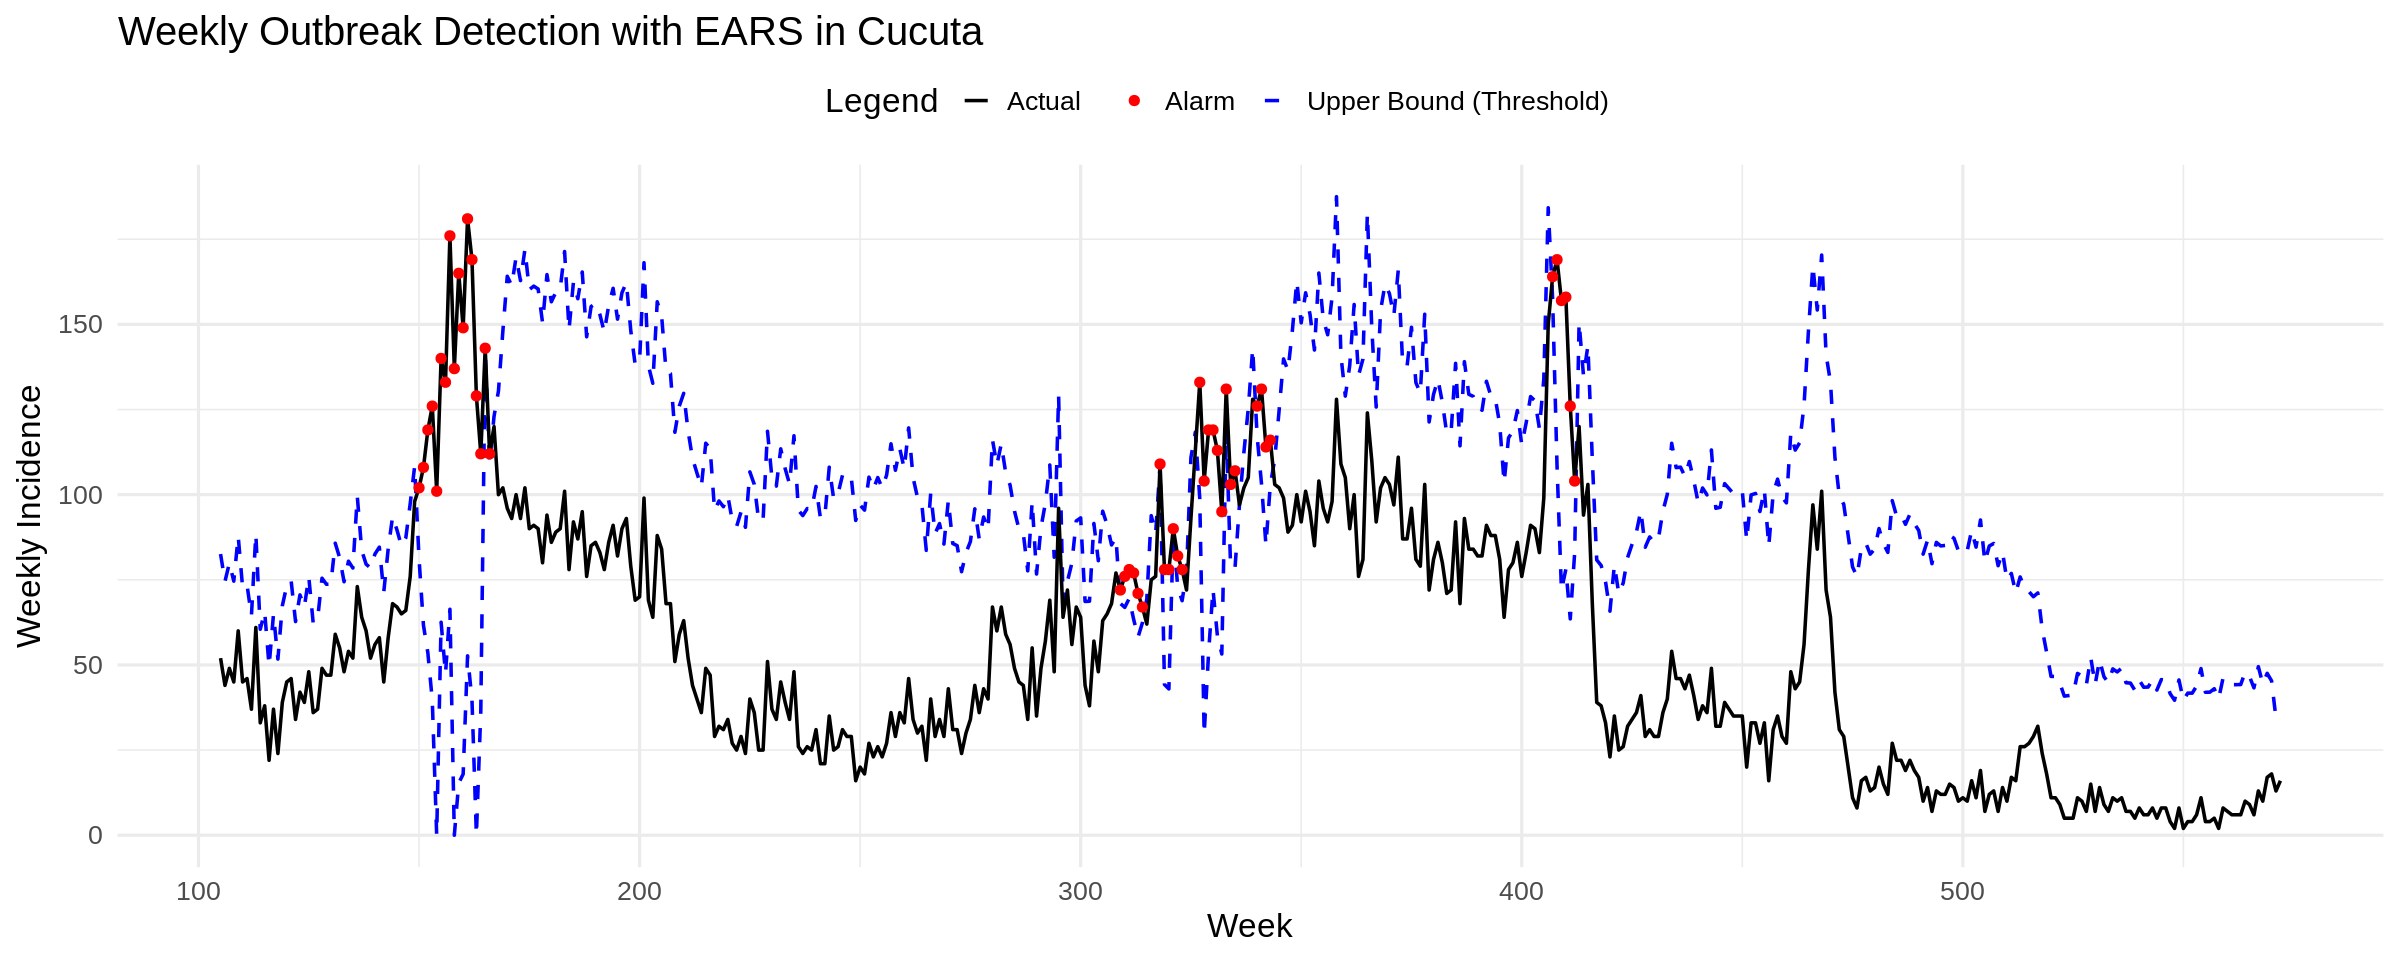

In [46]:
plot_detector_forecast(global_result_cucuta, "EARS", "Cucuta")

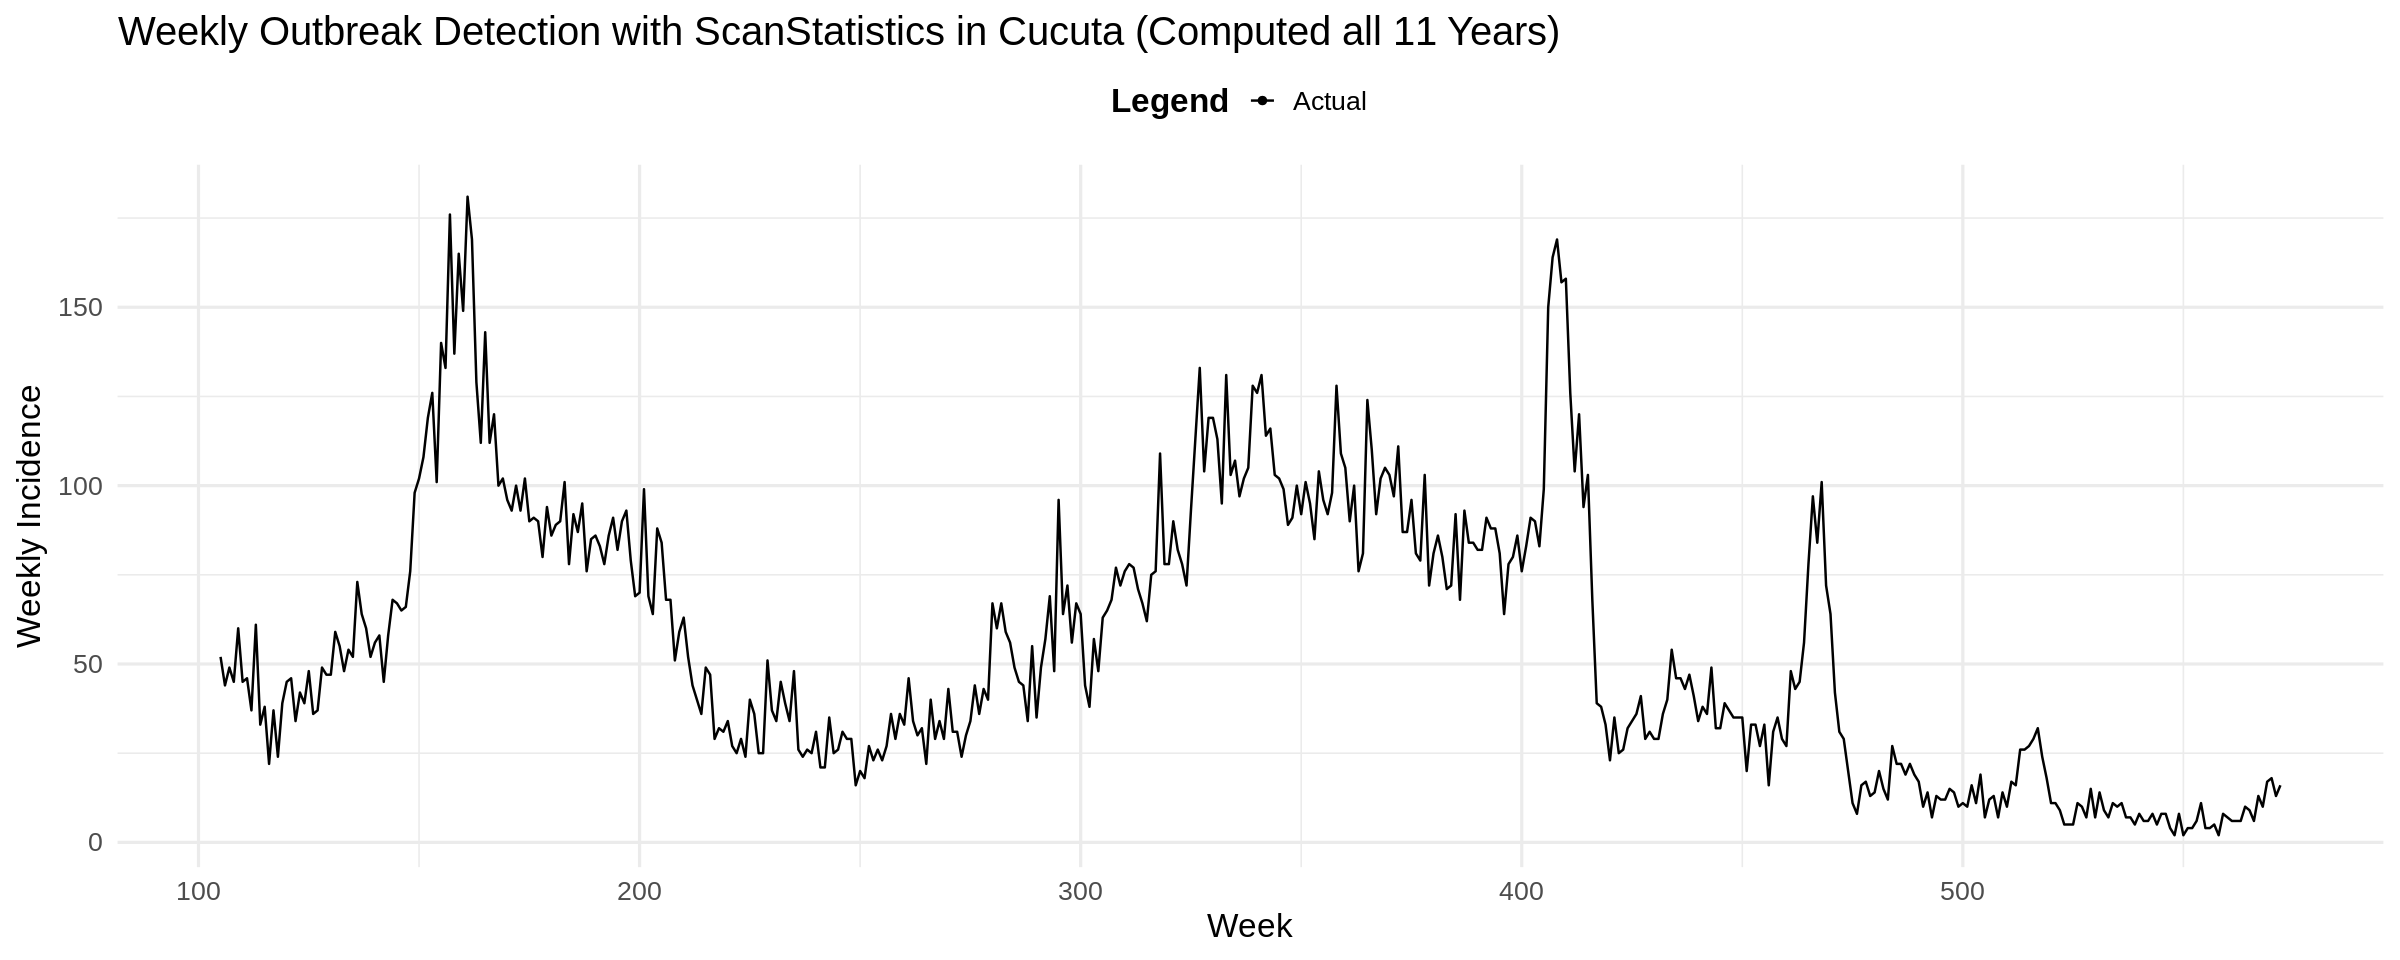

In [47]:
plot_scan(df = scan_res_11y, region = "Cucuta", extra_note = "(Computed all 11 Years)")

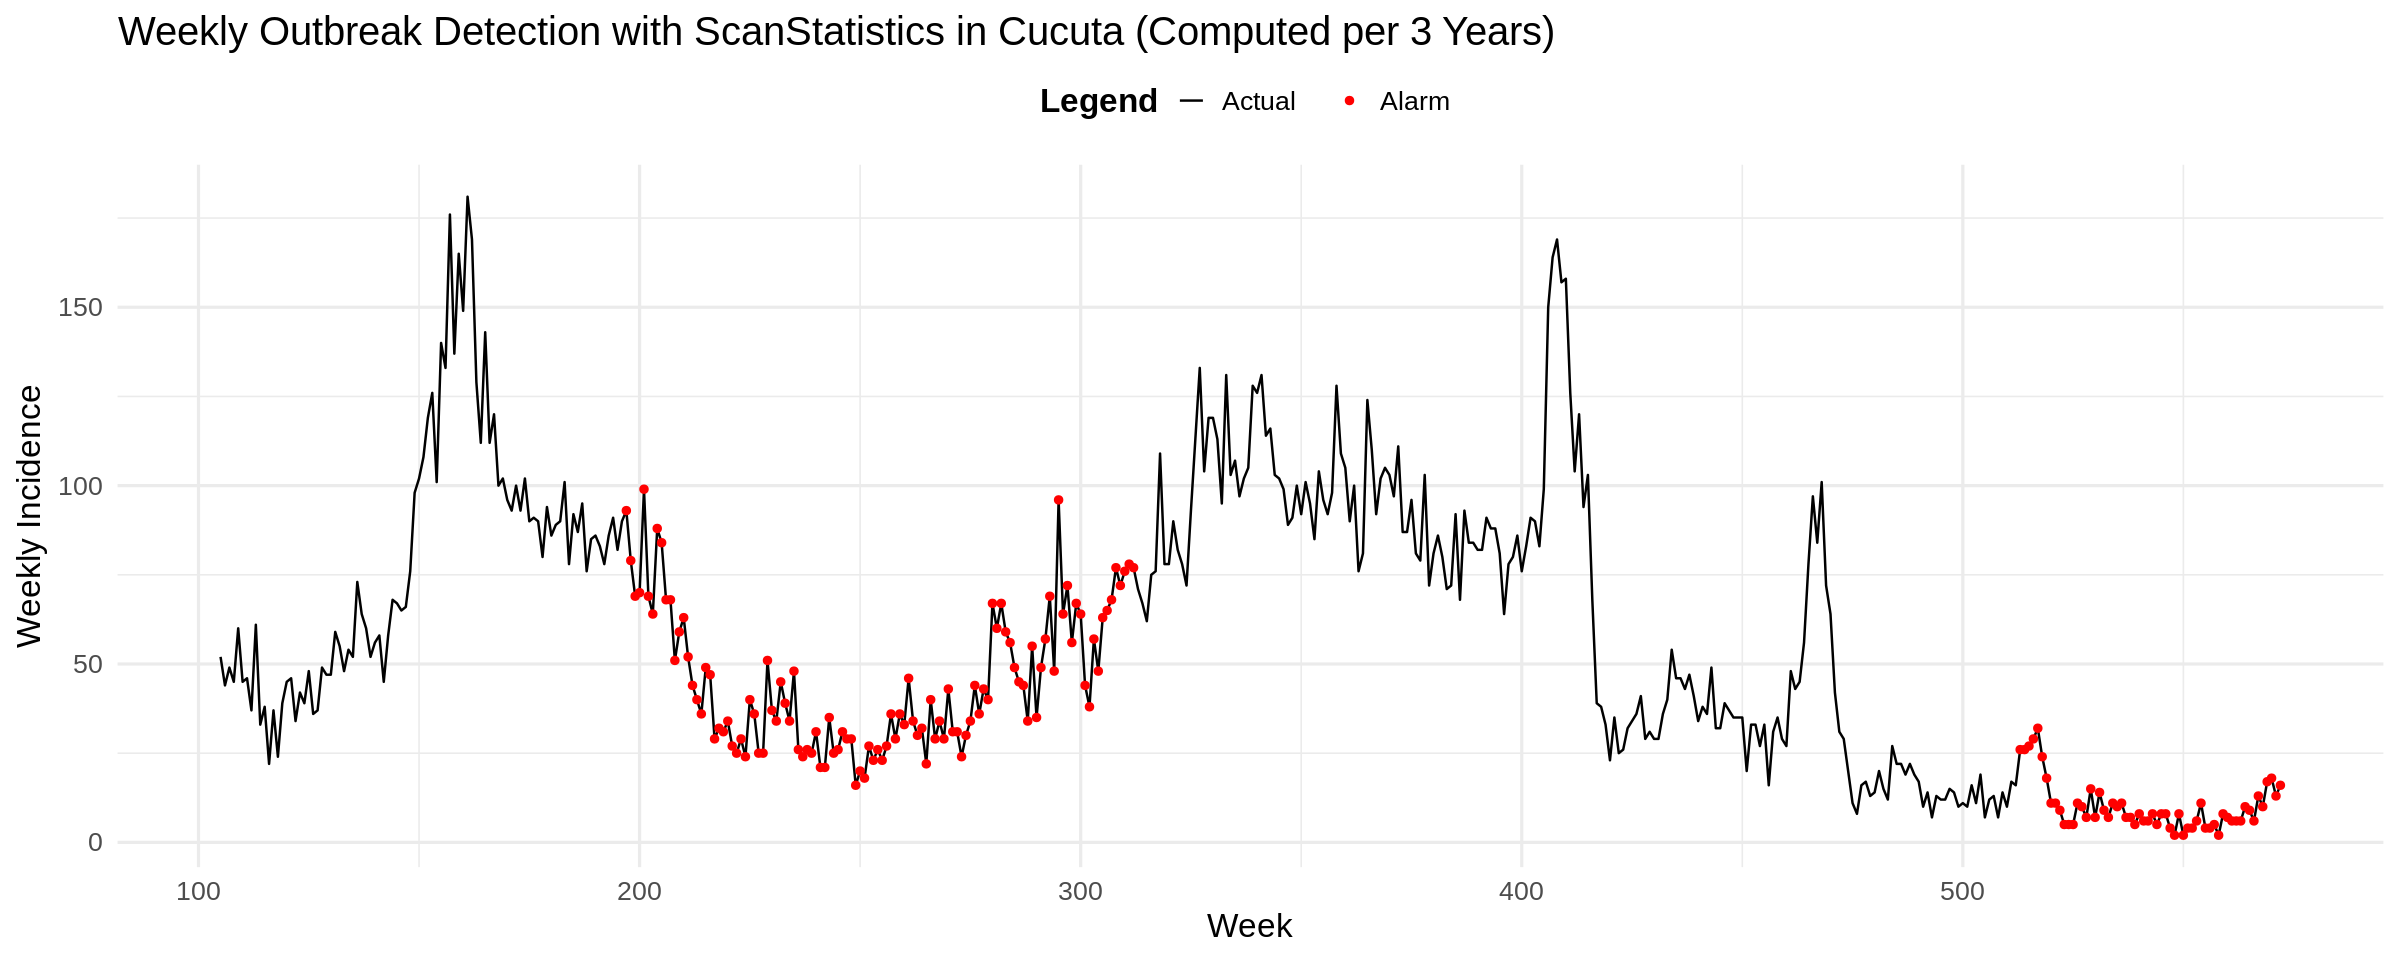

In [48]:
plot_scan(df = scan_res_3y, region = "Cucuta", extra_note = "(Computed per 3 Years)")

### Plot Outbreak Bello

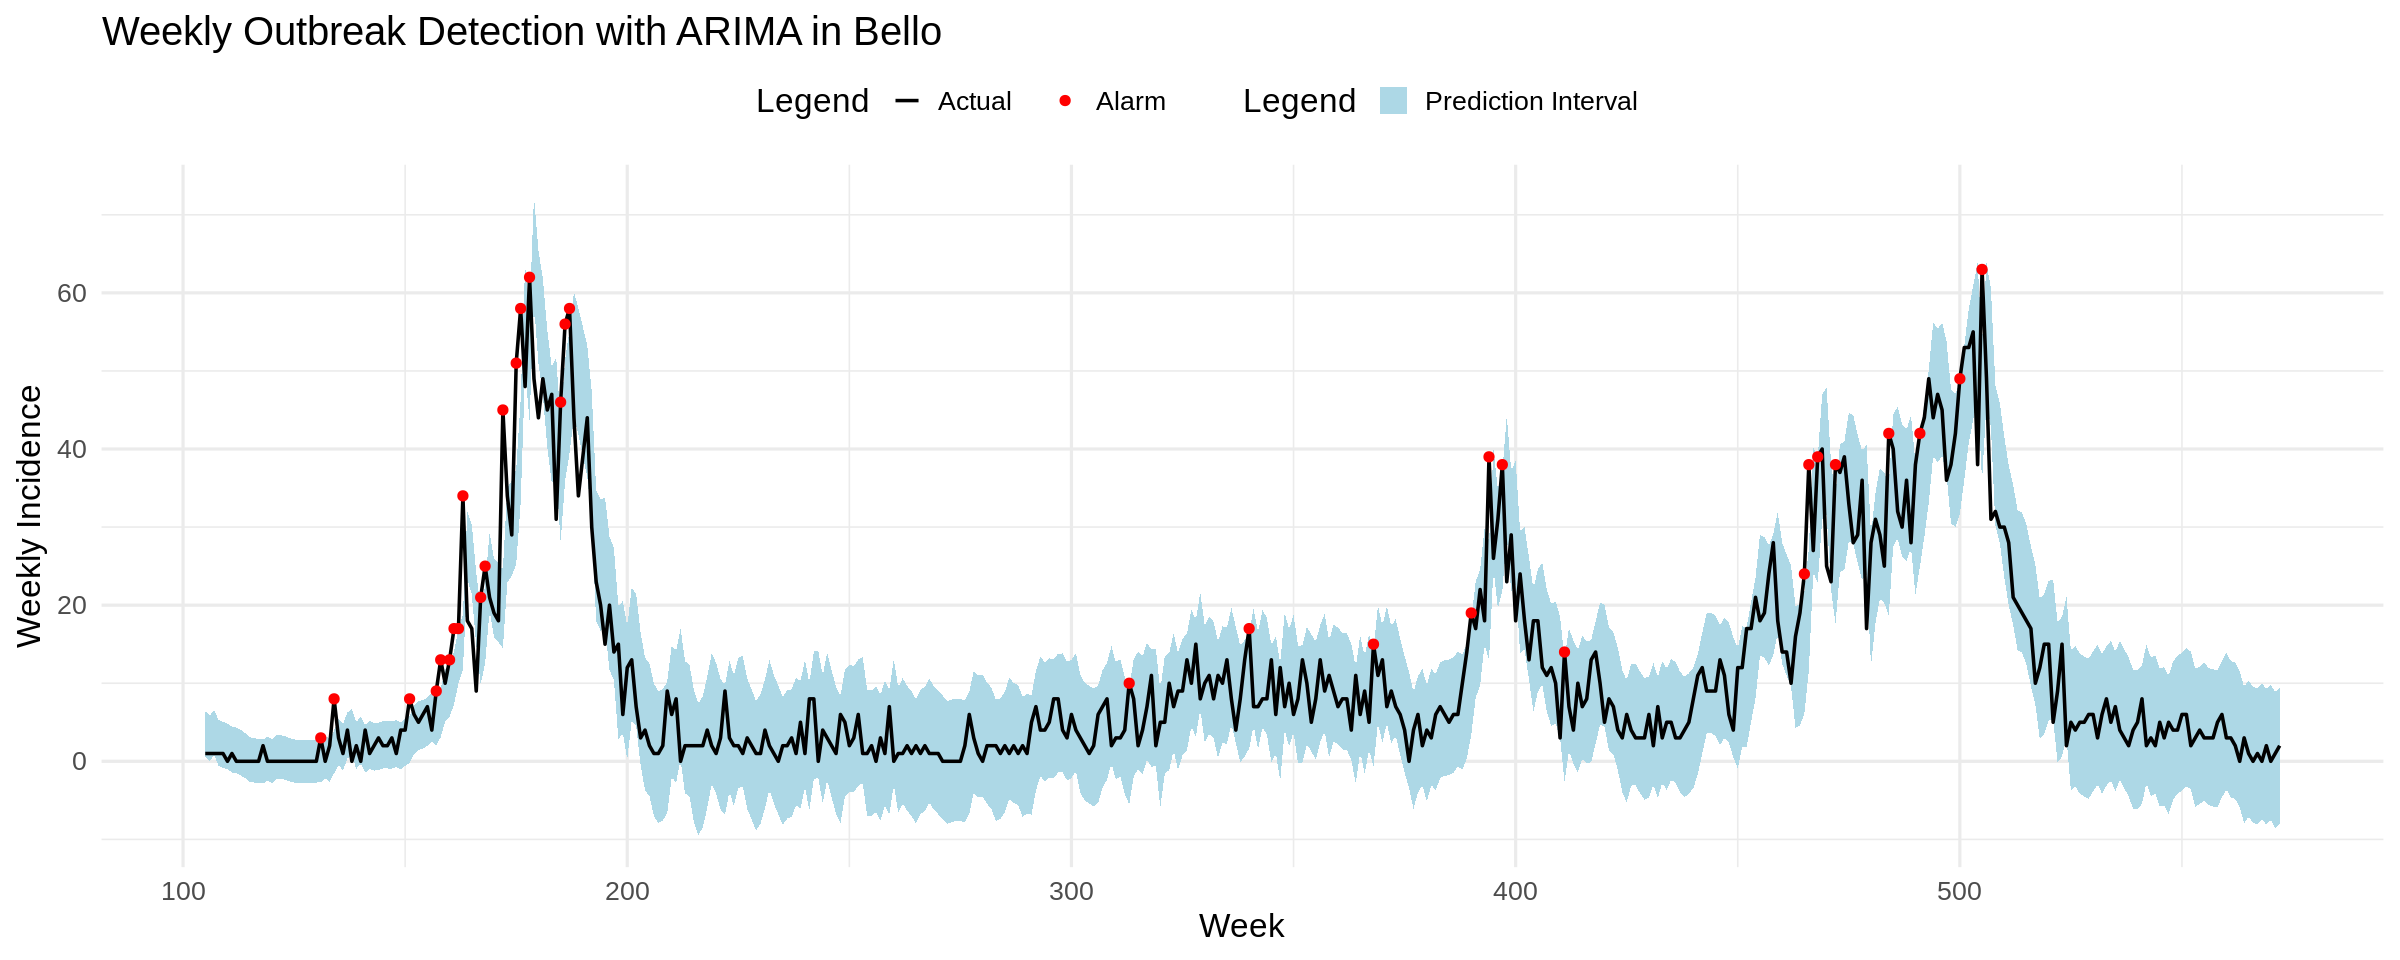

In [49]:
plot_detector_forecast(global_result_bello, "ARIMA", "Bello")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


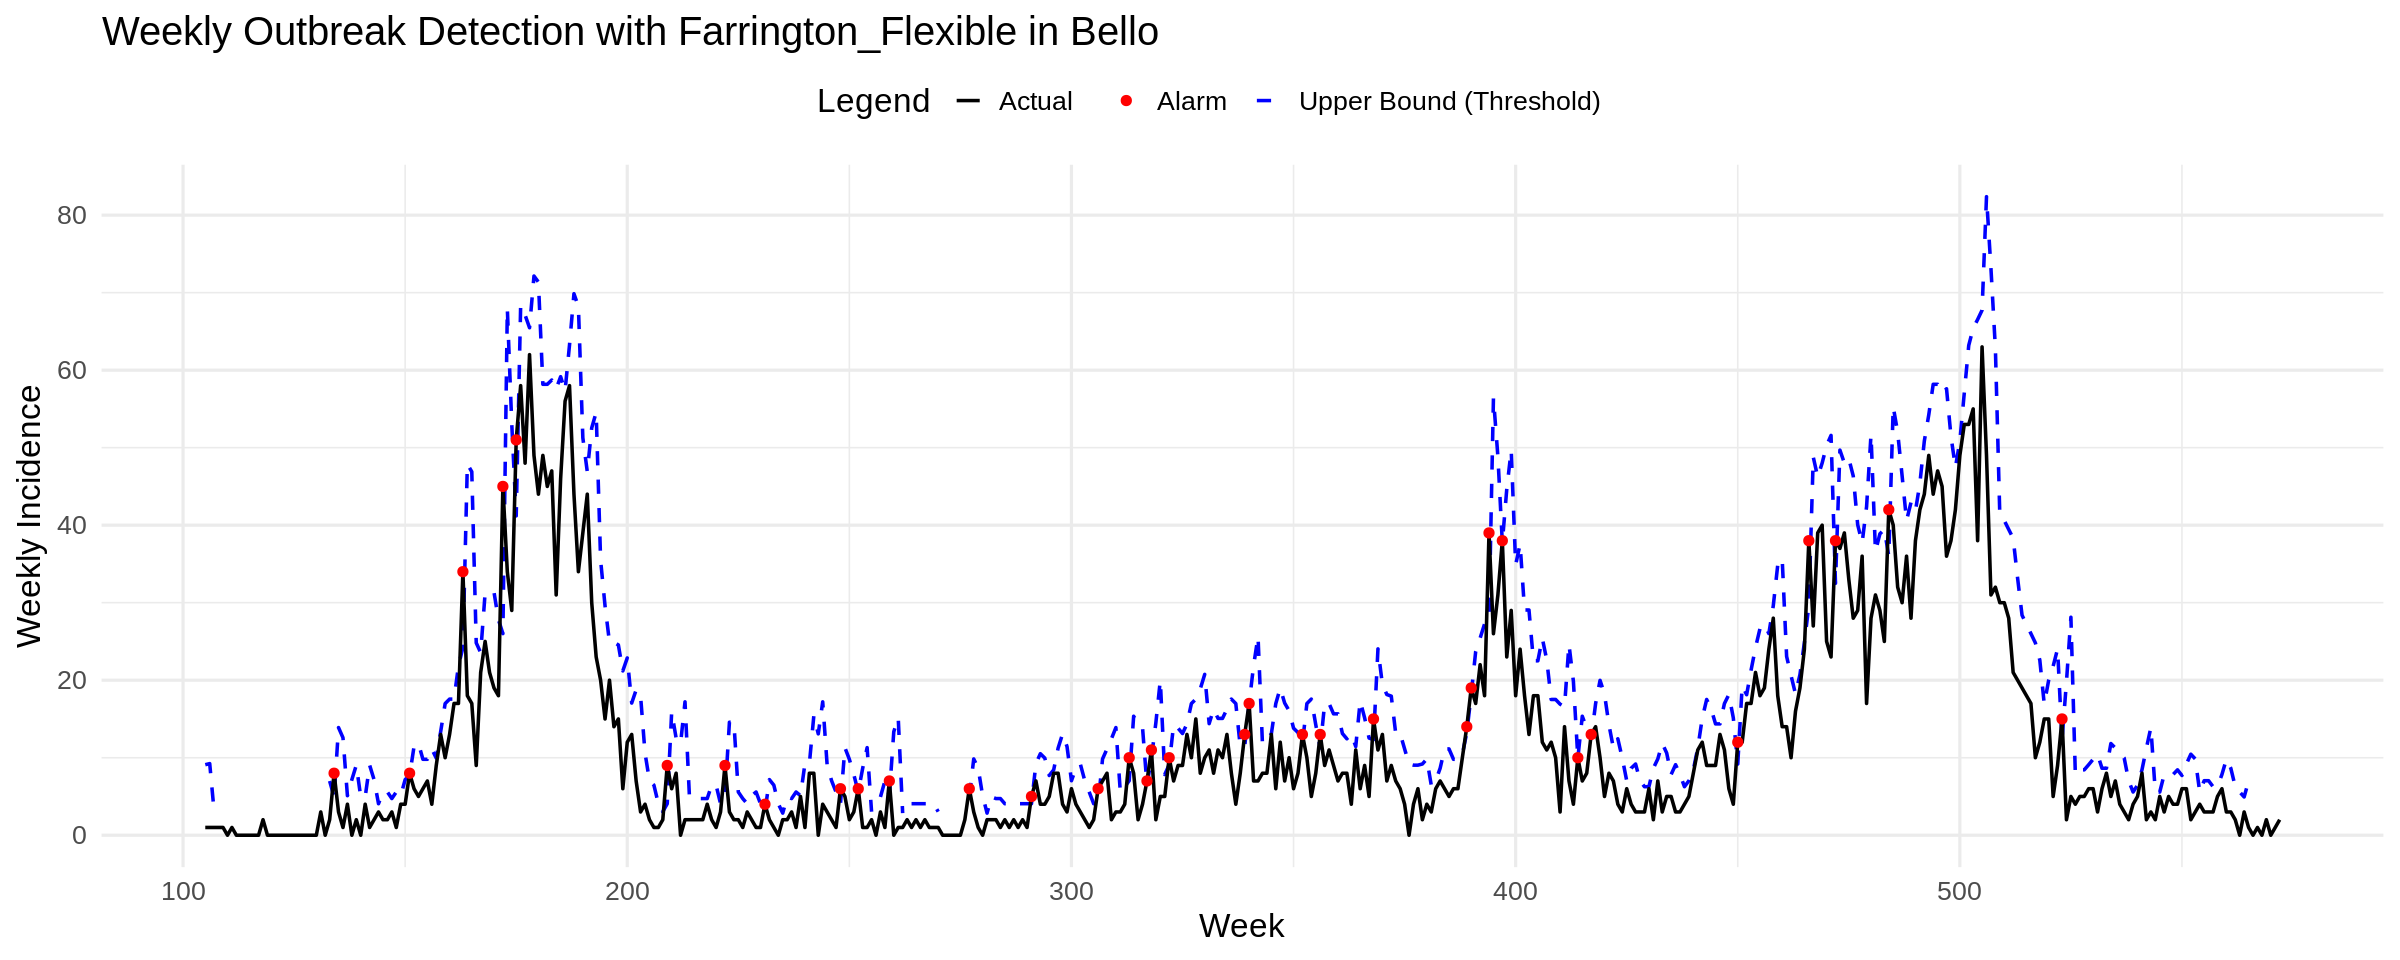

In [50]:
plot_detector_forecast(global_result_bello, "Farrington_Flexible", "Bello")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


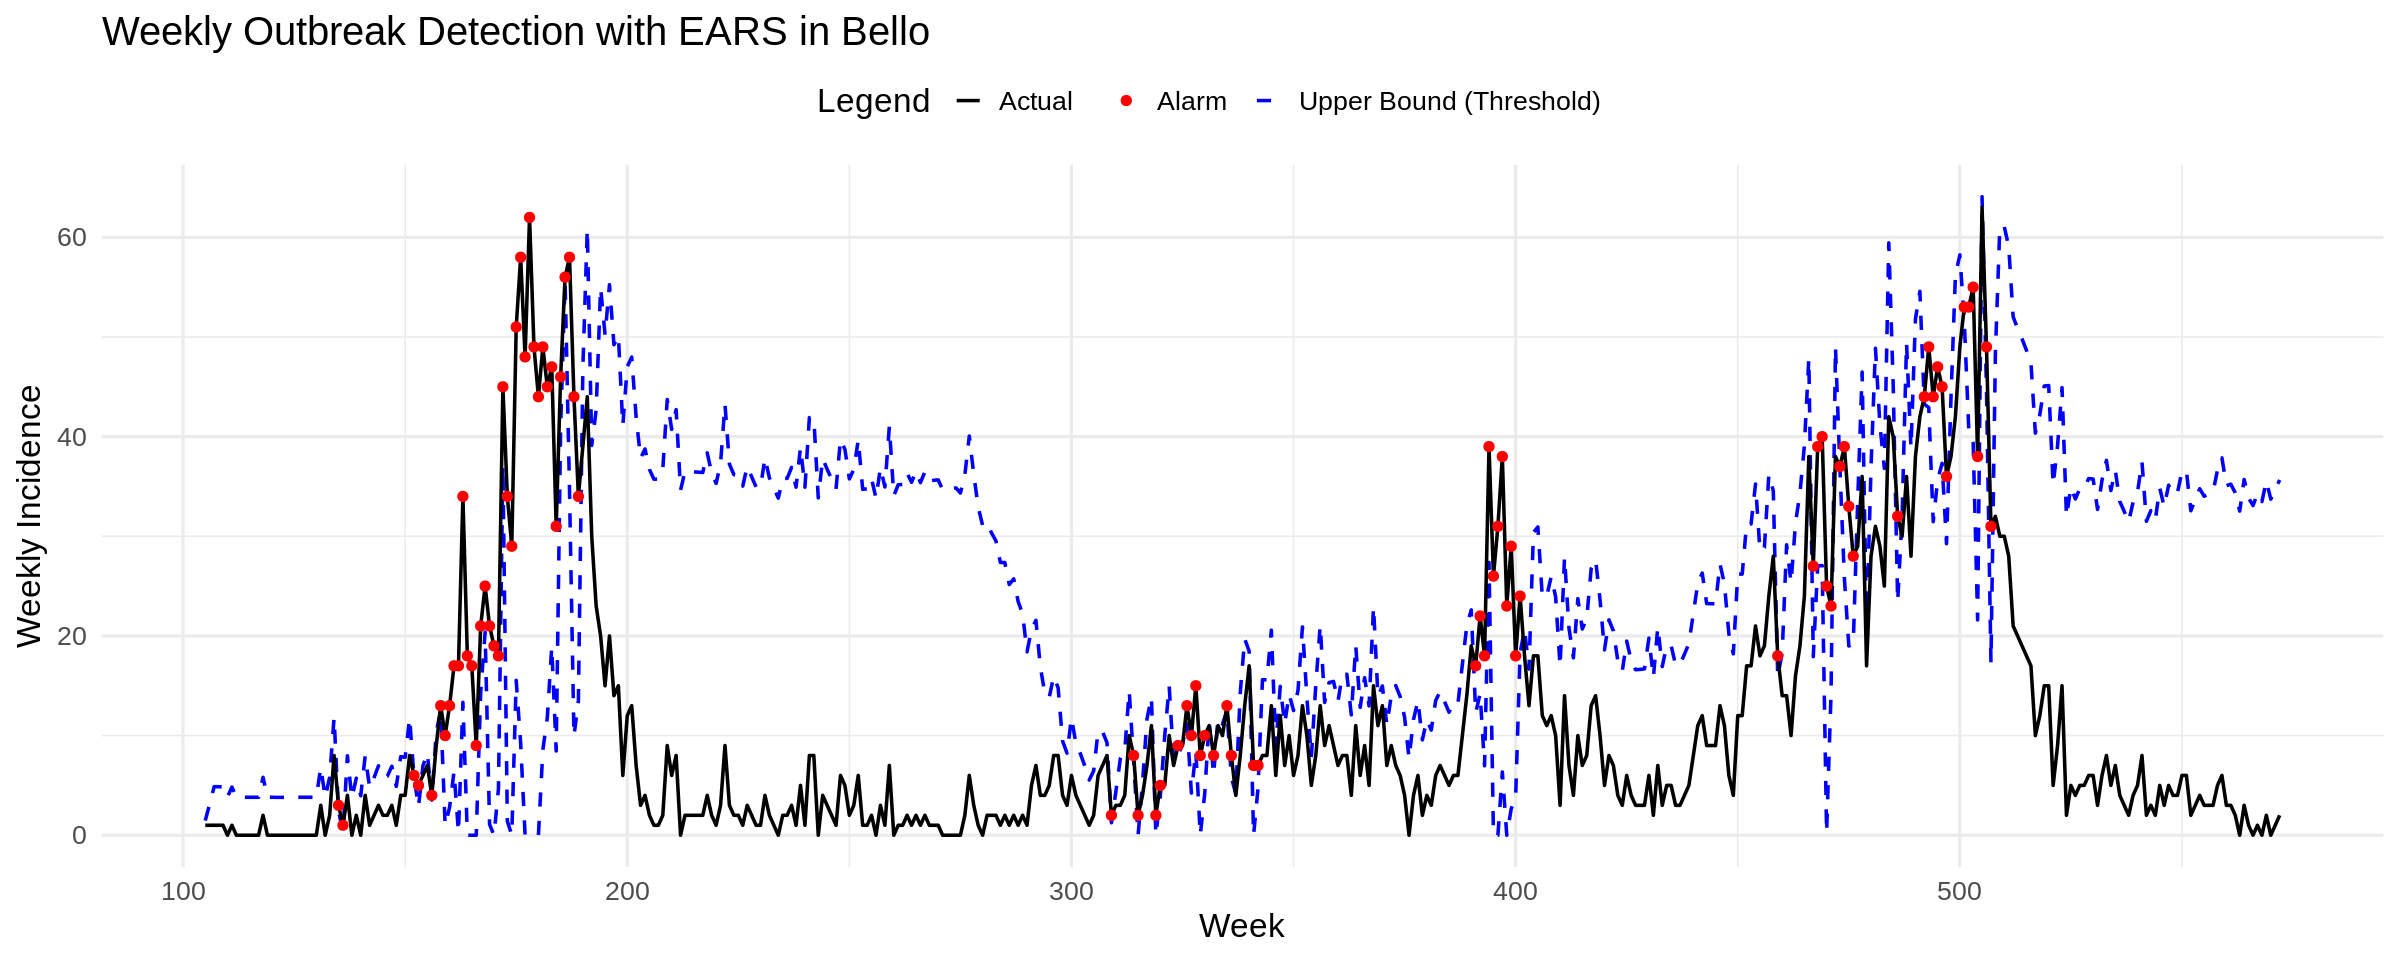

In [51]:
plot_detector_forecast(global_result_bello, "EARS", "Bello")

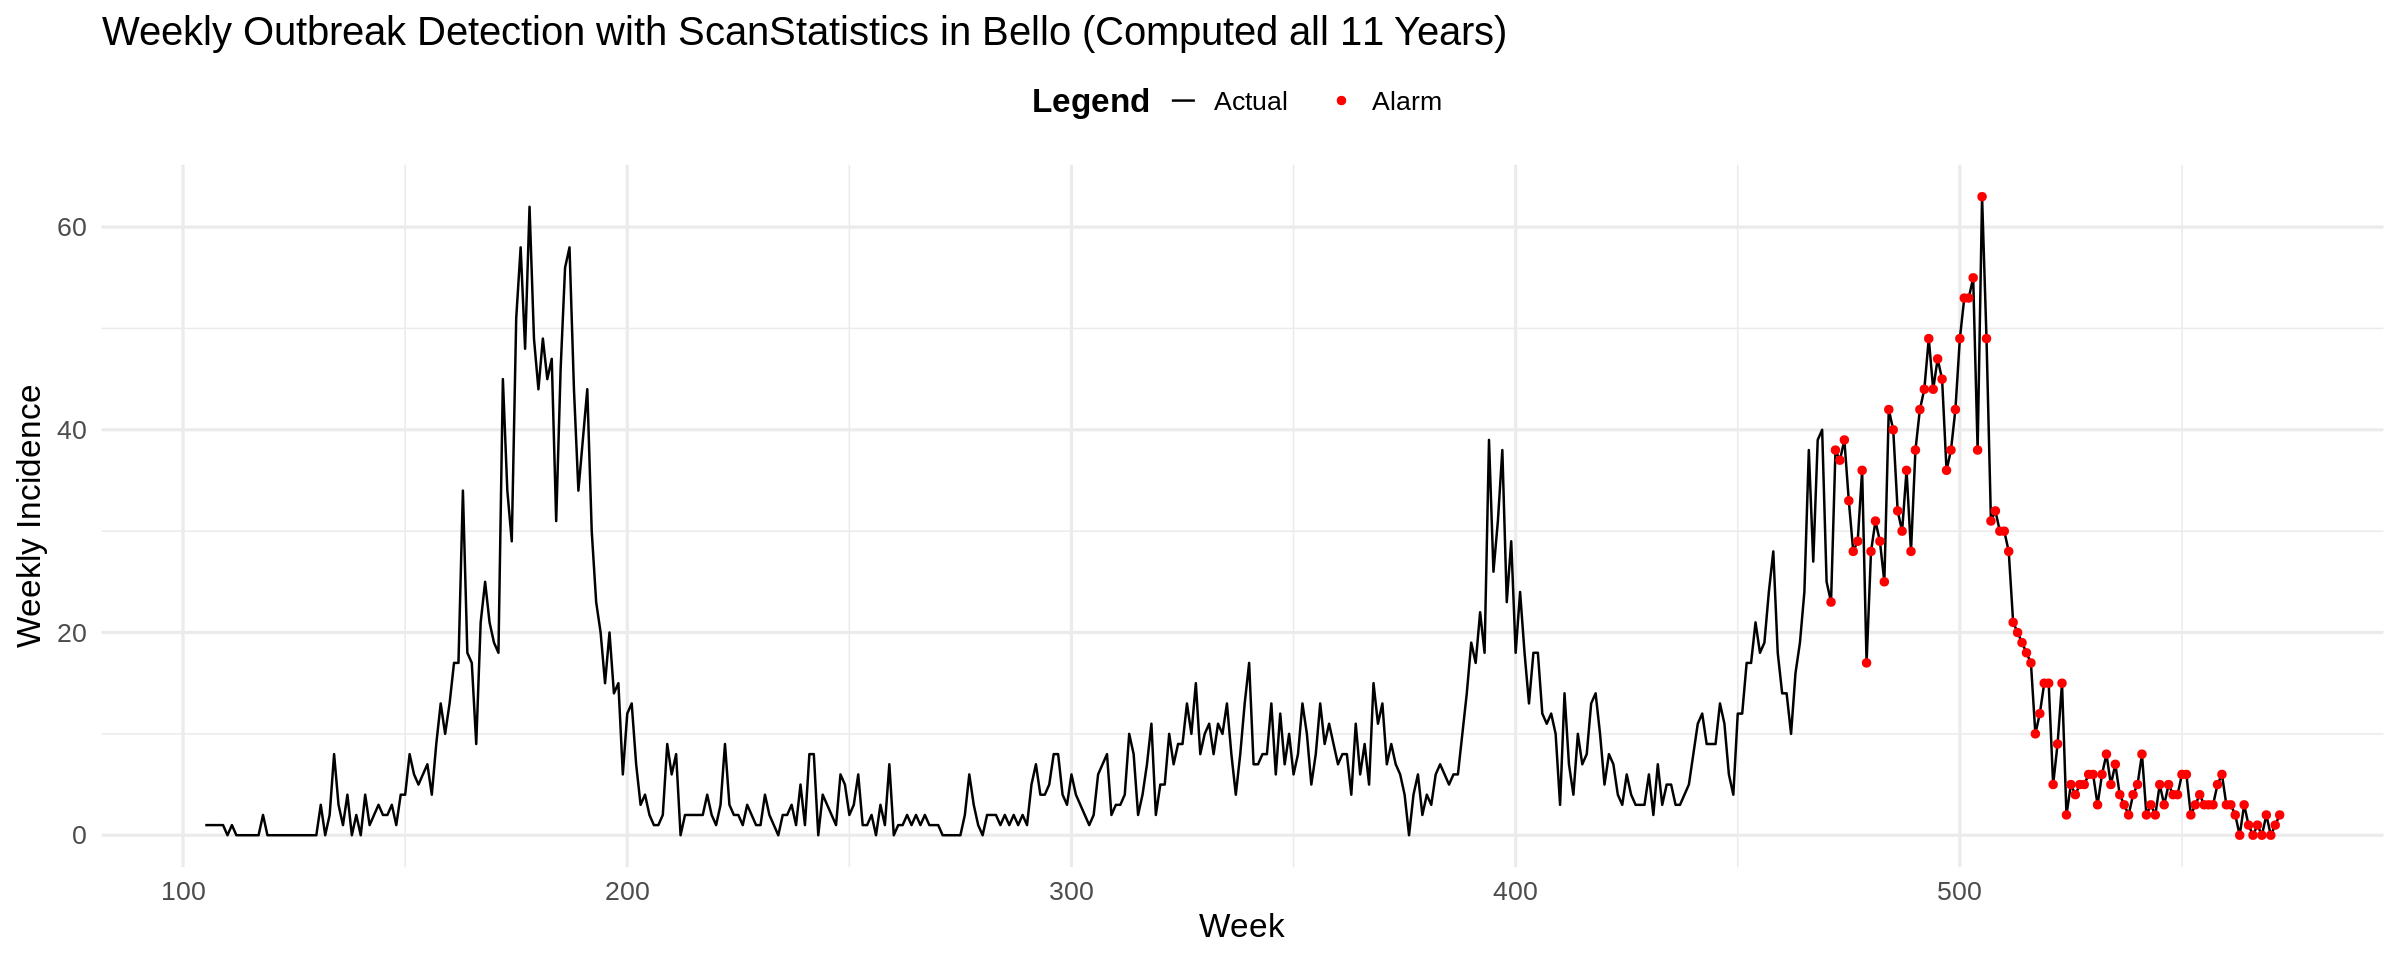

In [52]:
plot_scan(df = scan_res_11y, region = "Bello", extra_note = "(Computed all 11 Years)")

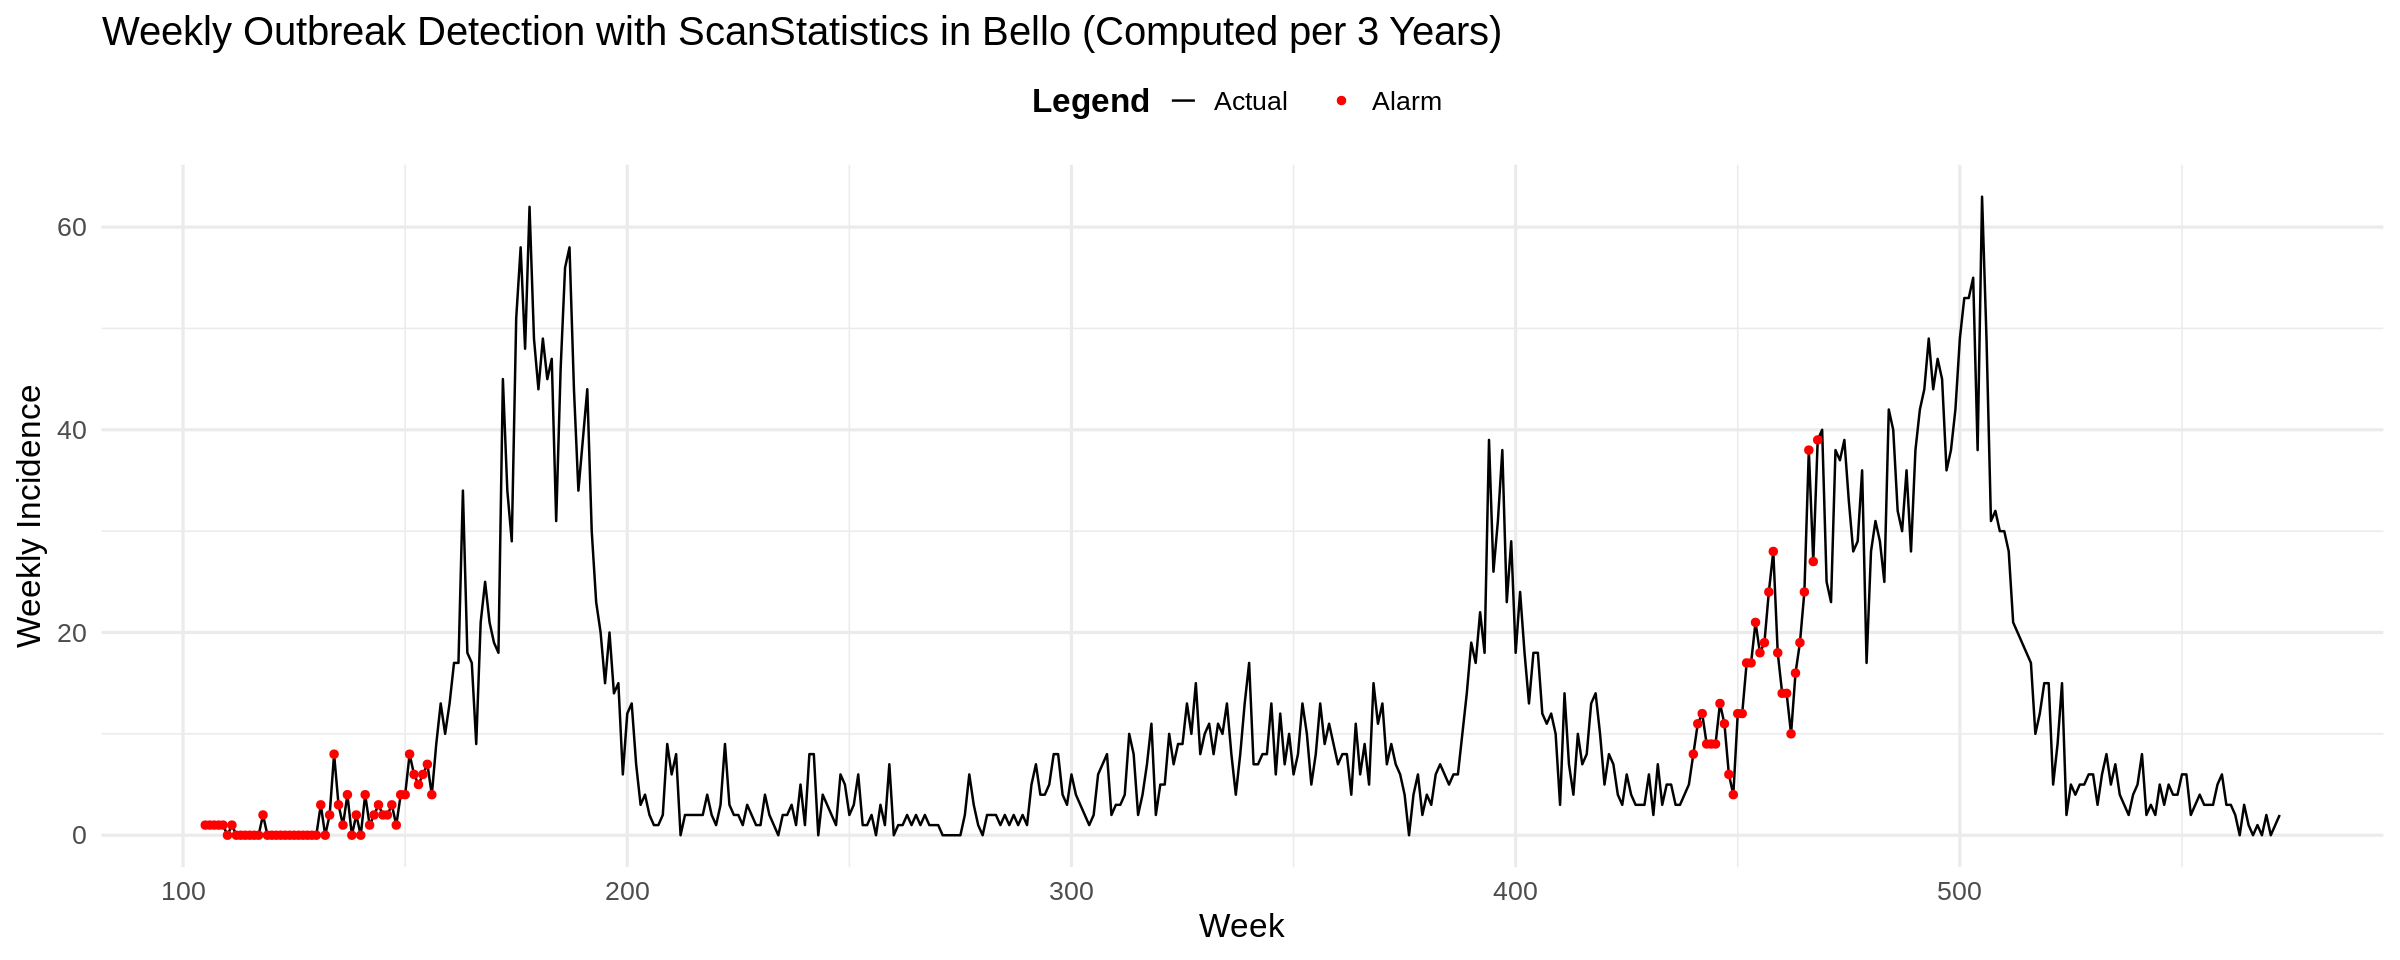

In [53]:
plot_scan(df = scan_res_3y, region = "Bello", extra_note = "(Computed per 3 Years)")

### Plot Outbreak Moniquira

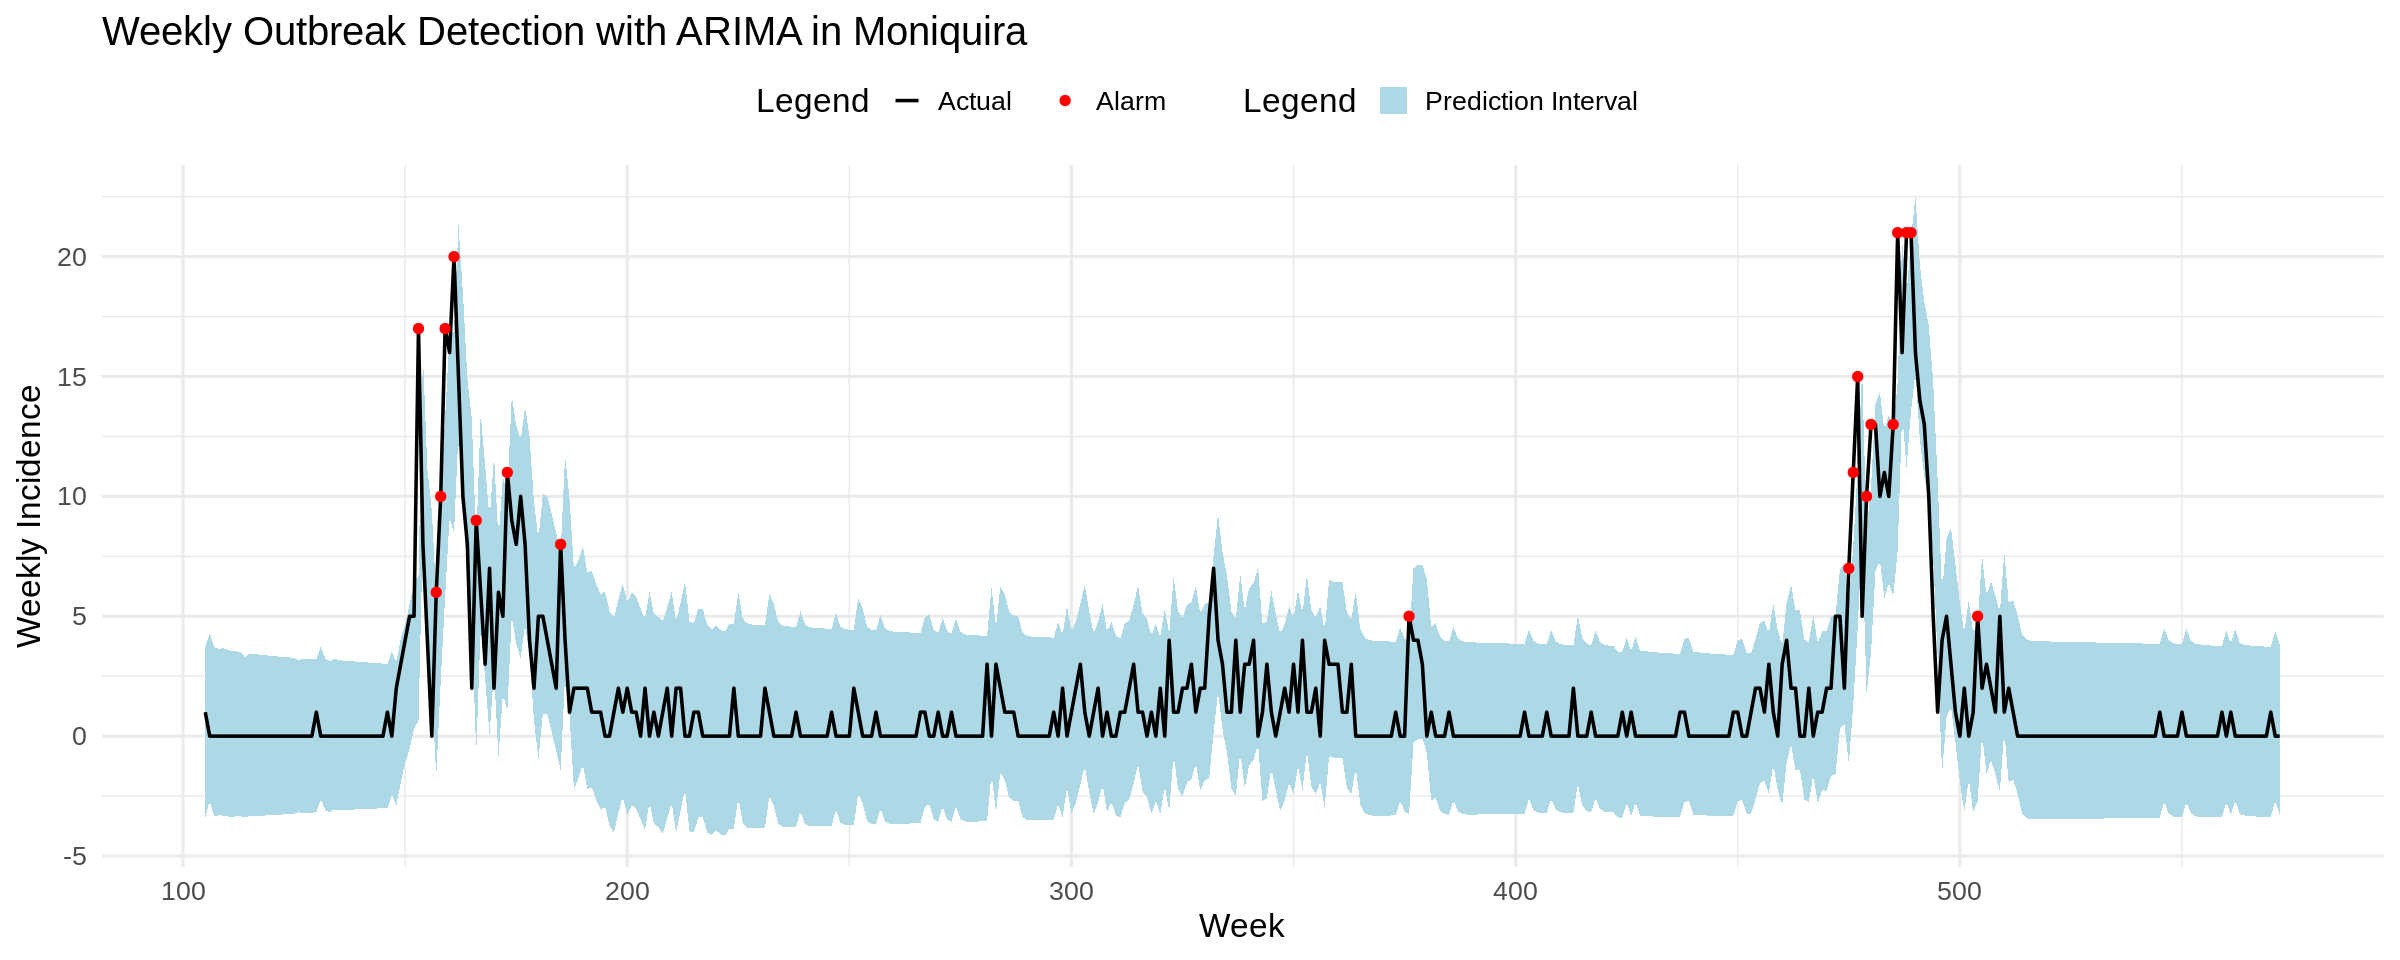

In [54]:
plot_detector_forecast(global_result_moni, "ARIMA", "Moniquira")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“Removed 104 rows containing missing values or values outside the scale range
(`geom_line()`).”


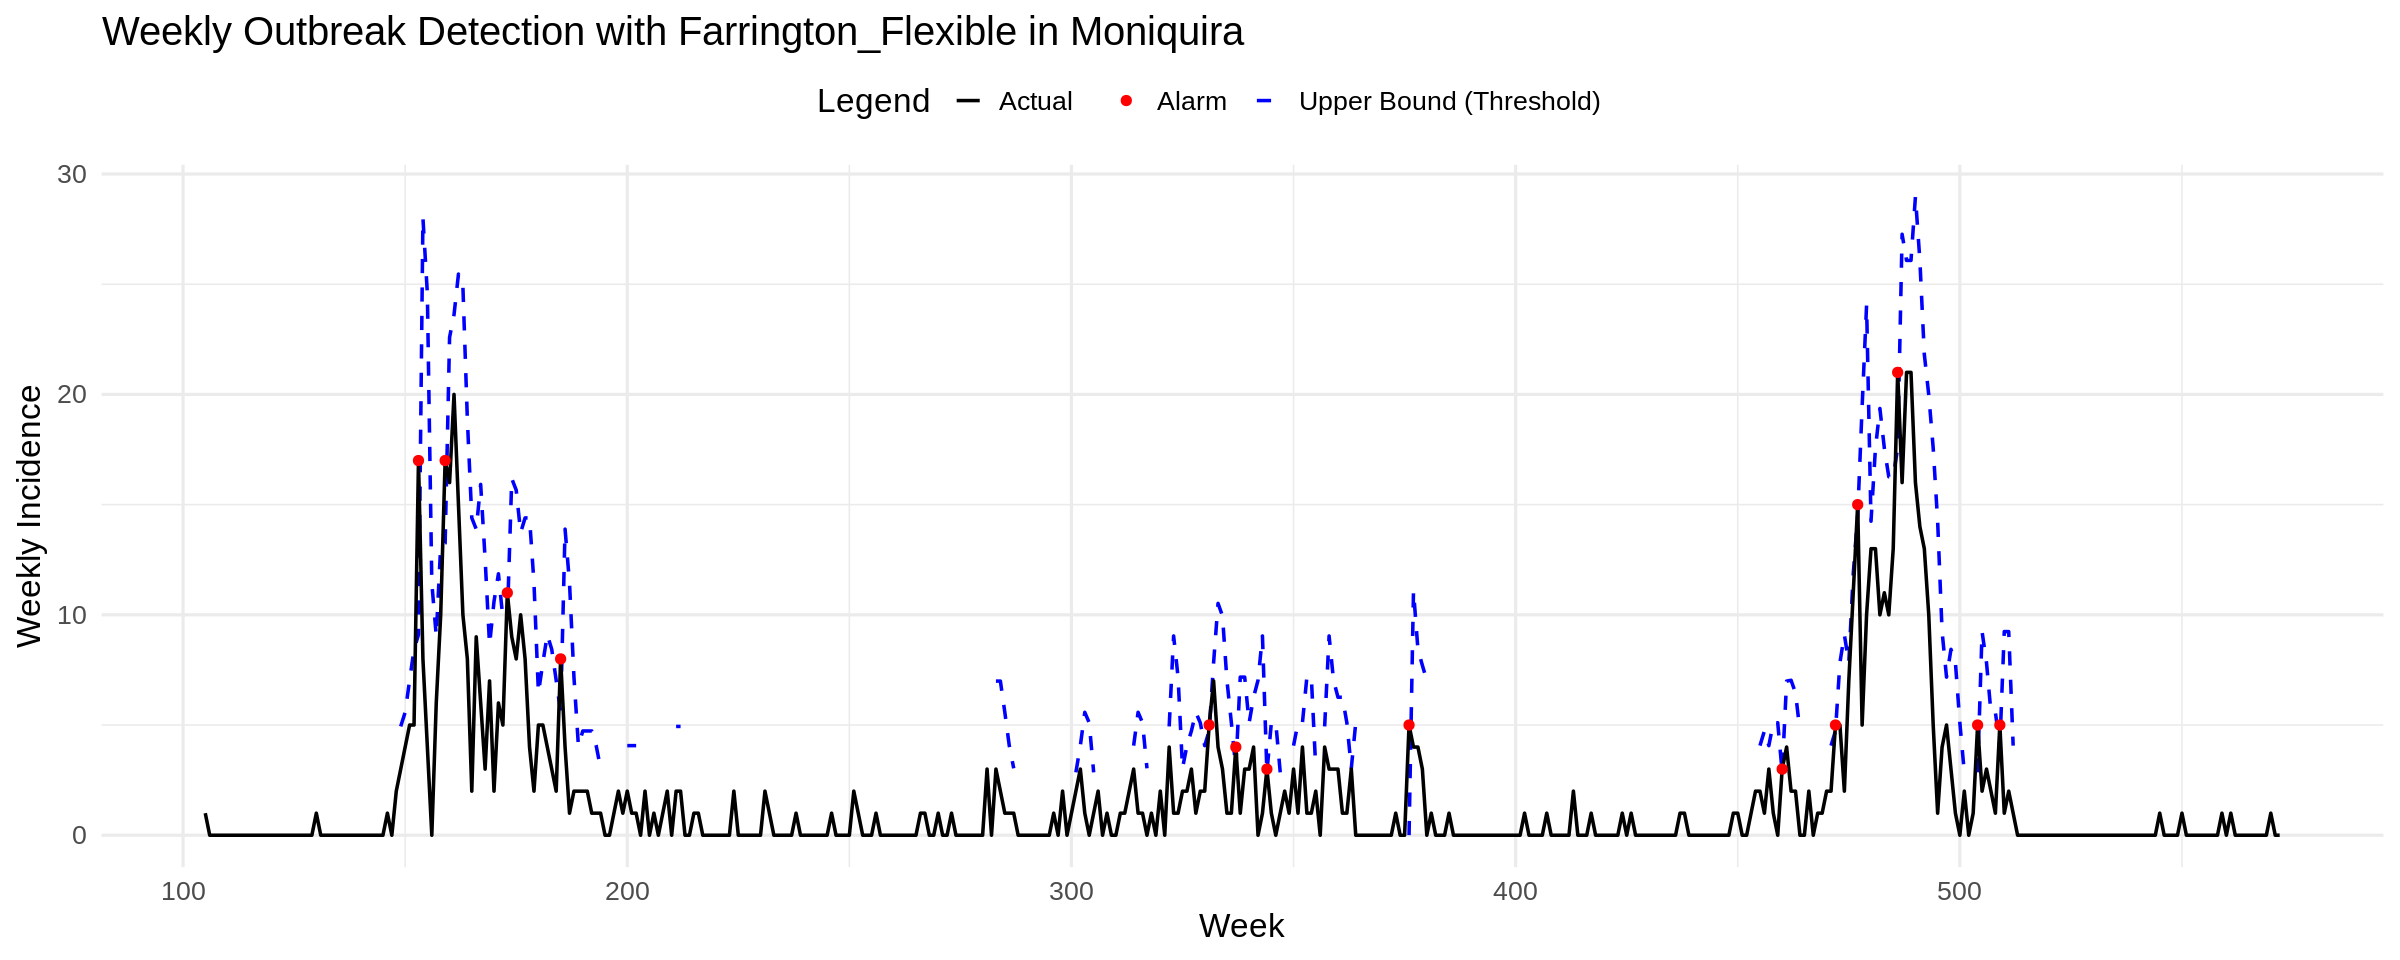

In [55]:
plot_detector_forecast(global_result_moni, "Farrington_Flexible", "Moniquira")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


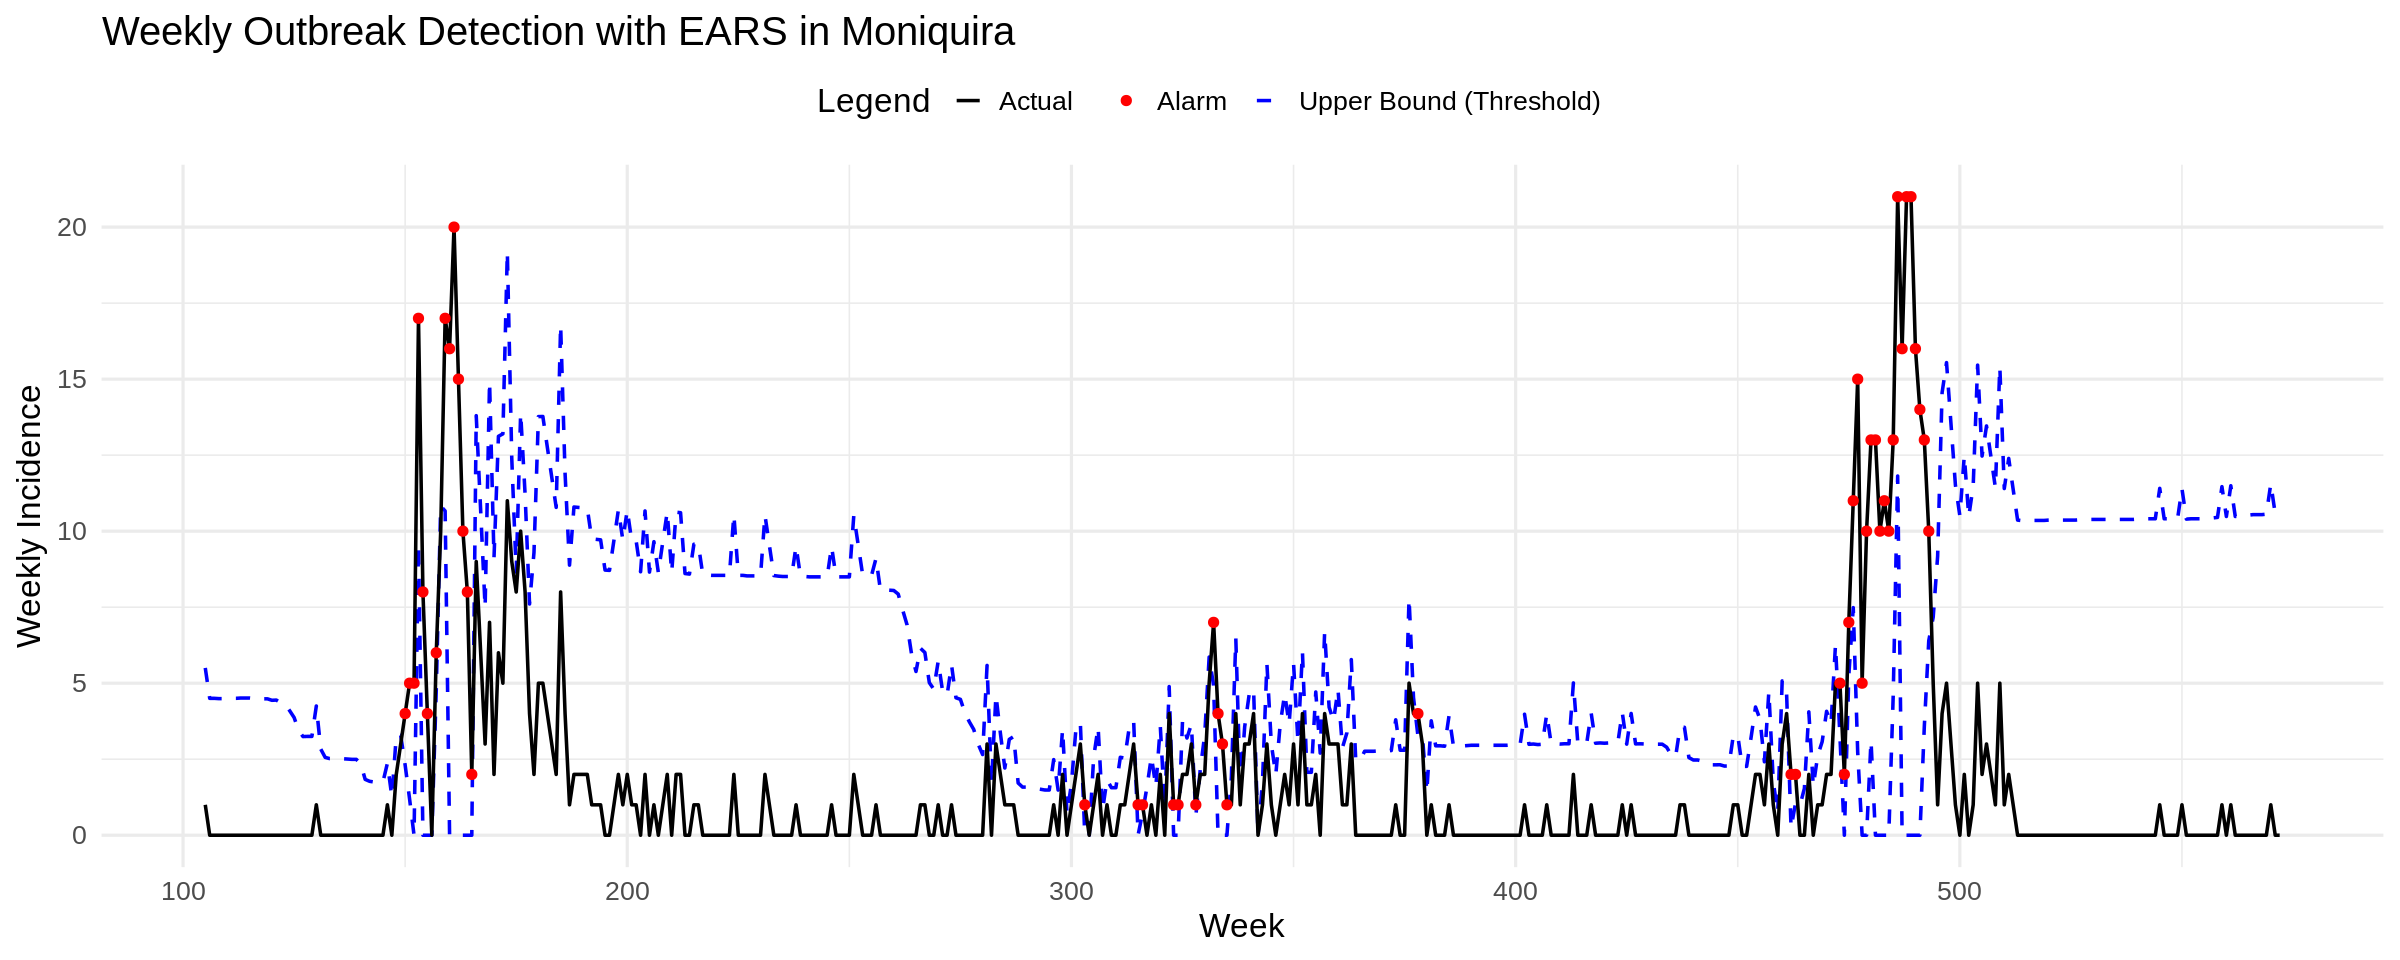

In [56]:
plot_detector_forecast(global_result_moni, "EARS", "Moniquira")

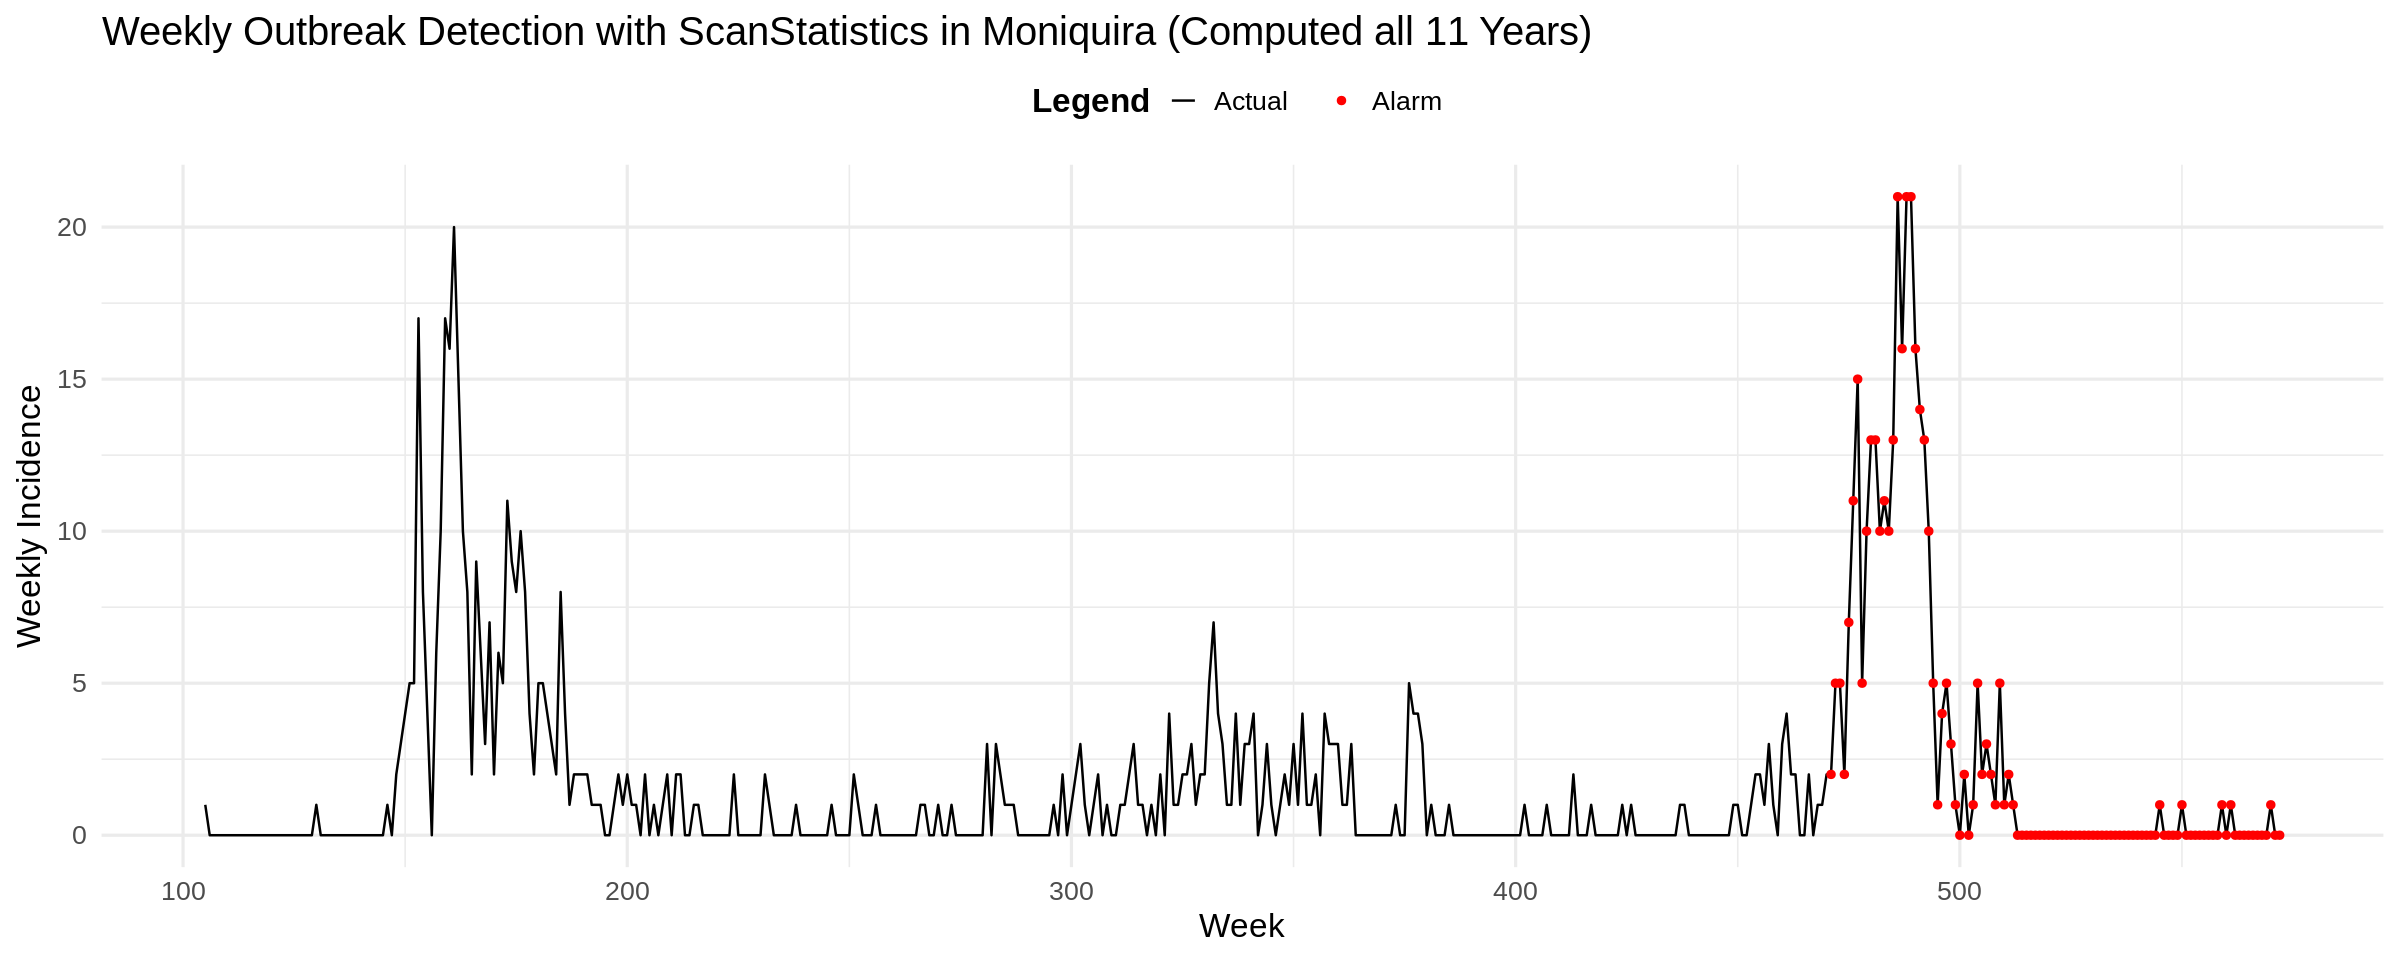

In [57]:
plot_scan(df = scan_res_11y, region = "Moniquira", extra_note = "(Computed all 11 Years)")

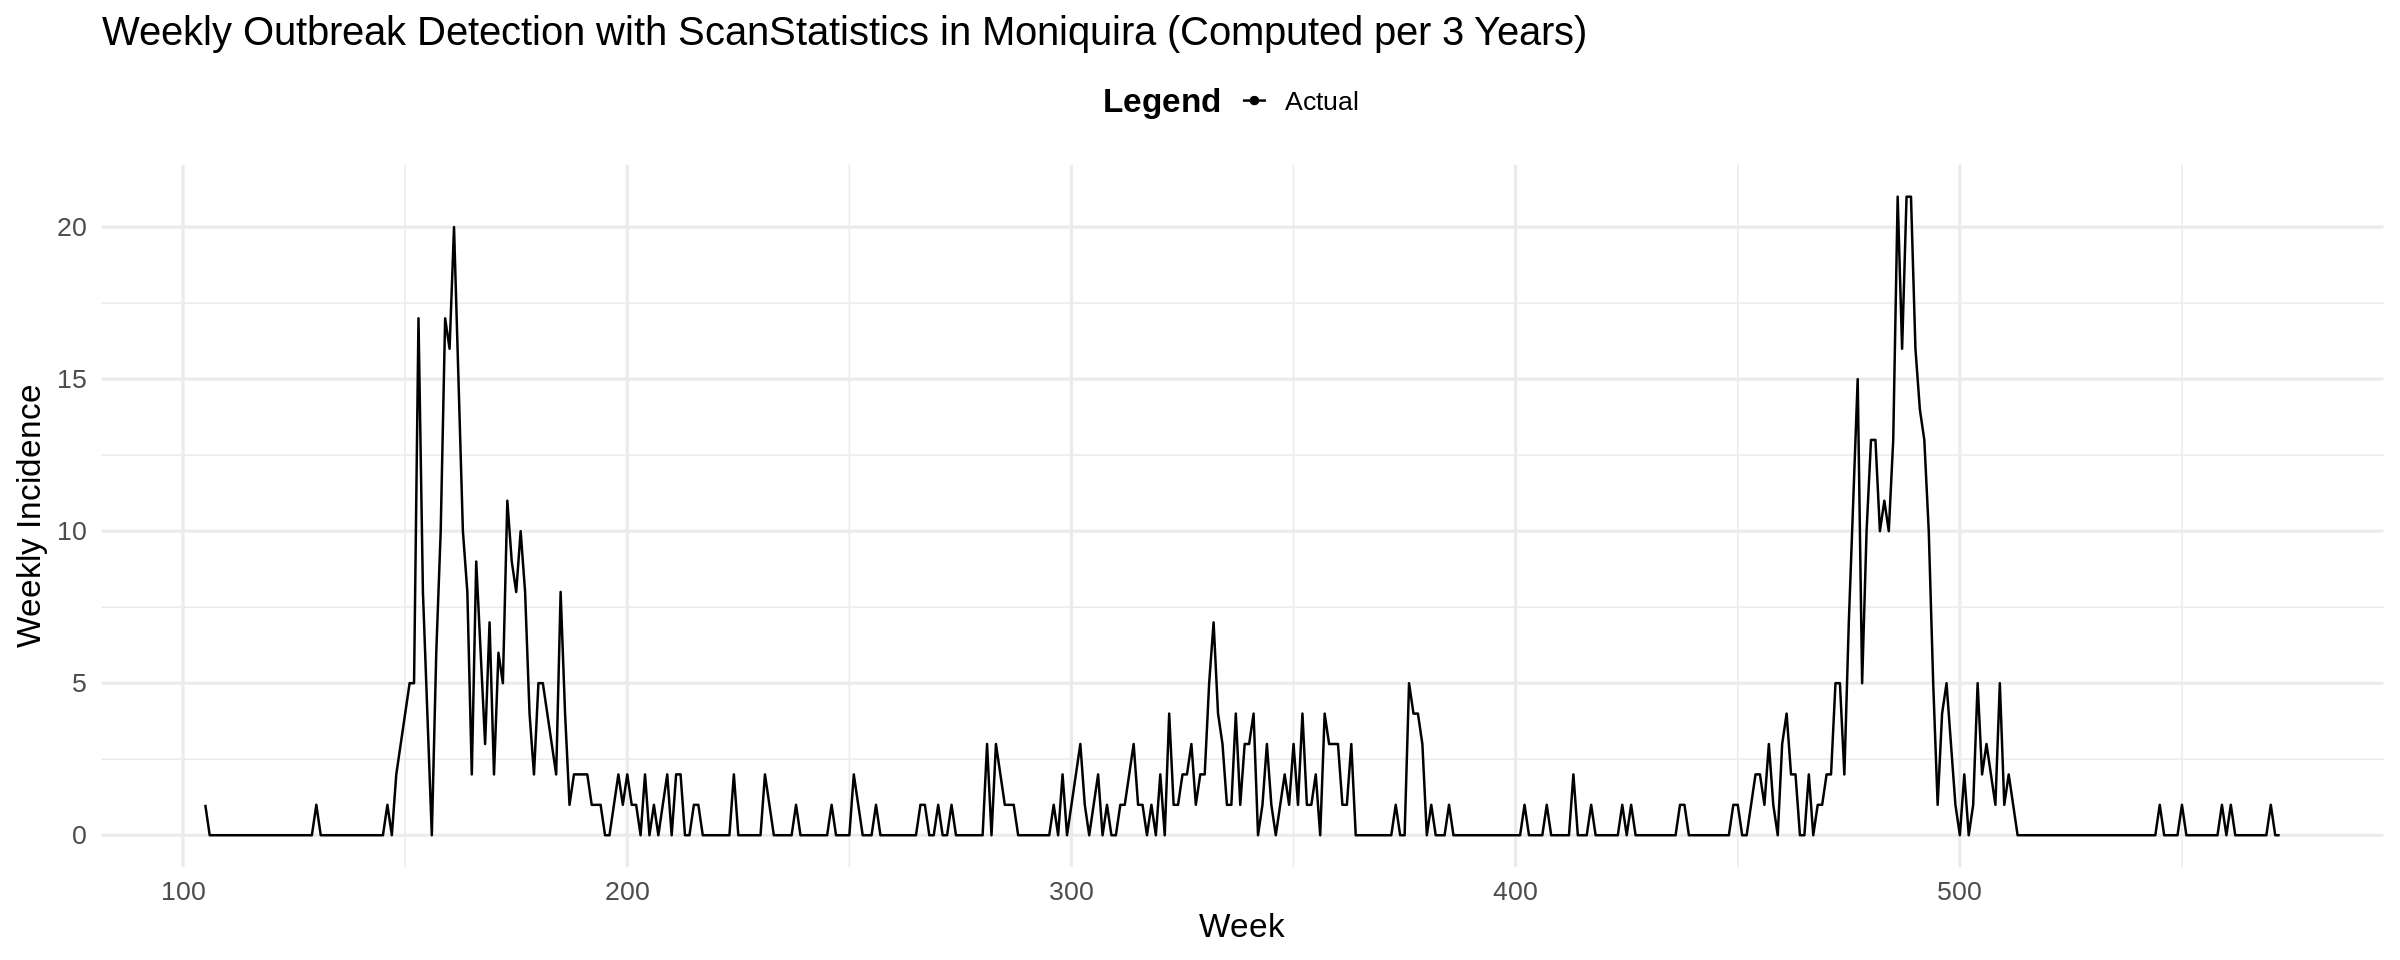

In [58]:
plot_scan(df = scan_res_3y, region = "Moniquira", extra_note = "(Computed per 3 Years)")

# Export to CSV to later processed into the evaluation framework

In [59]:
library(googledrive)
drive_auth()  # Drive Authentication

Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=5a59482e2ae31e82c06c4f8dd22d1b0c&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVZNQnNKajB6dElvNy1Pc09sYmxTaUE4MmNmeTltS3ltOEltX1NndDdZR2o1a1RnXzRqSDdtdmpWeWRvRWhvMEw1azQ1ZyIsInN0YXRlIjoiNWE1OTQ4MmUyYWUzMWU4MmMwNmM0ZjhkZDIyZDFiMGMifQ==


In [60]:
# Get the folder id (not sure why I can't just directly put the folder name to save the file)
mosquito_id <- drive_find(type = "folder", pattern = "Mosquito_Data") %>%
  filter(name == "Mosquito_Data") %>%
  pull(id)

In [61]:
# Re-organize exported data
exp_cucuta <- cucuta_dengue %>%
  inner_join(global_result_cucuta$signals, by = "Week") %>%
  inner_join(global_result_cucuta$pval, by = "Week")

head(exp_cucuta, 2)
tail(exp_cucuta, 2)

write.csv(exp_cucuta, "dengue_cucuta.csv", row.names = FALSE)
drive_upload("dengue_cucuta.csv", path = as_id(mosquito_id), overwrite = TRUE)

Municipality Year Week_inY Reported_Cases Population Week Farrington_Flexible
1 Cucuta       2009 1        52             612175     105  0                  
2 Cucuta       2009 2        44             612175     106  0                  
  EARS ARIMA Farrington_Flexible_pval ARIMA_pval
1 0    0     0.2519255                0.1537144 
2 0    0     0.3955936                0.7366595

Municipality Year Week_inY Reported_Cases Population Week Farrington_Flexible
1 Cucuta       2017 51       13             662673     571  0                  
2 Cucuta       2017 52       16             662673     572  0                  
  EARS ARIMA Farrington_Flexible_pval ARIMA_pval
1 0    0     0.8702499                0.6348279 
2 0    0     0.4503745                0.4389379

File trashed:

• dengue_cucuta.csv <id: 113kGJEgGKmPwfKgX13xFeJ05zuLRPXFu>

Local file:

• dengue_cucuta.csv

Uploaded into Drive file:

• dengue_cucuta.csv <id: 17hI0MYE_IkKqnZYovvh6xttdvedD16Vc>

With MIME type:

• text/csv



In [62]:
# Re-organize exported data
exp_bello <- bello_dengue %>%
  inner_join(global_result_bello$signals, by = "Week") %>%
  inner_join(global_result_bello$pval, by = "Week")

head(exp_bello, 2)
tail(exp_bello, 2)

write.csv(exp_bello, "dengue_bello.csv", row.names = FALSE)
drive_upload("dengue_bello.csv", path = as_id(mosquito_id), overwrite = TRUE)

Municipality Year Week_inY Reported_Cases Population Week Farrington_Flexible
1 Bello        2009 1        1              404895     105  0                  
2 Bello        2009 2        1              404895     106  0                  
  EARS ARIMA Farrington_Flexible_pval ARIMA_pval
1 0    0     0.9863435                0.9249363 
2 0    0     0.7778167                0.8627093

Municipality Year Week_inY Reported_Cases Population Week Farrington_Flexible
1 Bello        2017 51       1              473423     571  0                  
2 Bello        2017 52       2              473423     572  0                  
  EARS ARIMA Farrington_Flexible_pval ARIMA_pval
1 0    0     0.5000000                0.4336187 
2 0    0     0.1271678                0.4035062

File trashed:

• dengue_bello.csv <id: 1yw3JZA6xxppkyx_wOWgM4RSiL8B0vlOl>

Local file:

• dengue_bello.csv

Uploaded into Drive file:

• dengue_bello.csv <id: 1vnajuq9Opv3zAq-SbywAVXdXzy2MVWJB>

With MIME type:

• text/csv



In [63]:
# Re-organize exported data
exp_moni <- moni_dengue %>%
  inner_join(global_result_moni$signals, by = "Week") %>%
  inner_join(global_result_moni$pval, by = "Week")

head(exp_moni, 2)
tail(exp_moni, 2)

write.csv(exp_moni, "dengue_moni.csv", row.names = FALSE)
drive_upload("dengue_moni.csv", path = as_id(mosquito_id), overwrite = TRUE)

Municipality Year Week_inY Reported_Cases Population Week Farrington_Flexible
1 Moniquira    2009 1        1              21716      105  0                  
2 Moniquira    2009 2        0              21716      106  0                  
  EARS ARIMA Farrington_Flexible_pval ARIMA_pval
1 0    0     0.0000000                0.3495018 
2 0    0     0.7733726                0.6460743

Municipality Year Week_inY Reported_Cases Population Week Farrington_Flexible
1 Moniquira    2017 51       0              21284      571  0                  
2 Moniquira    2017 52       0              21284      572  0                  
  EARS ARIMA Farrington_Flexible_pval ARIMA_pval
1 0    0     0.7733726                0.6528192 
2 0    0     0.7733726                0.5514688

File trashed:

• dengue_moni.csv <id: 14kUg0h7FuOxY-Ne_t1MpmsJC70i1Uf8p>

Local file:

• dengue_moni.csv

Uploaded into Drive file:

• dengue_moni.csv <id: 1JmT19_5Ko3MPdL3ma2C49528yaD5J-b1>

With MIME type:

• text/csv



In [64]:
# Re-organize exported scan data
write.csv(scan_res_11y, "scan_detect_11y.csv", row.names = FALSE)
drive_upload("scan_detect_11y.csv", path = as_id(mosquito_id), overwrite = TRUE)

File trashed:

• scan_detect_11y.csv <id: 1rDa4Sz1kU7Aiio-zQ1hdGdEESmiJJXAN>

Local file:

• scan_detect_11y.csv

Uploaded into Drive file:

• scan_detect_11y.csv <id: 15HwaAhGKZjLYSea8n1vv64pShTDP7KSc>

With MIME type:

• text/csv



In [65]:
# Re-organize exported scan data
write.csv(scan_res_3y, "scan_detect_3y.csv", row.names = FALSE)
drive_upload("scan_detect_3y.csv", path = as_id(mosquito_id), overwrite = TRUE)

File trashed:

• scan_detect_3y.csv <id: 138P_Qb-mms9GViyp-EXNlAxsdgyI7gz_>

Local file:

• scan_detect_3y.csv

Uploaded into Drive file:

• scan_detect_3y.csv <id: 1dRaqfUtZq6oKwC24aOqI-UZL_KuwGEIa>

With MIME type:

• text/csv

